# King County House Sales Analysis

## Overview

A large real estate firm in the Seattle area is seeking to maximize prices for home sellers.  My task is to use data from previous home sales to predict future prices.  

## Business Problem
The real estate firm operates throughout King County, which includes the metropolis of Seattle, as well as suburban and rural areas.  Home prices vary greatly between these diverse landscapes, as well as between neighborhoods in Seattle.  The firm needs to accurately price a home based on data such as its size, location, and number of bedrooms, in order to get the best sale price for its clients.  It needs a model that can generate a good estimate of value for any home in the county.

## Data Understanding

To build a model to predict  prices, I used data from the King County House Sales dataset, which can be found here:

(https://www.kaggle.com/harlfoxem/housesalesprediction)

This dataset contains information on over 21,000 houses sold in King County between May, 2014 and May, 2015.  Although the median sale price is \\$450,000, the dataset also includes multi-million dollar homes.  At the top of the market are about 1,000 properties which sold between \\$1.2 million and \\$7.7 million, so the price data are right-skewed with a few very high outliers.

In addition to sale price, the dataset includes details about the homes, including square footage, lot square footage, number of bedrooms, zip code, and the dates when the houses were built, renovated, and sold.  Although the data seem mostly accurate, some values are missing, and many columns have outliers on the high side.

Definitions of all column names are below:

### Column Names and Descriptions for King County Data Set

* **id** - unique identifier for a house
* **date** - house was sold
* **price** -  is prediction target
* **bedrooms** -  number of bedrooms
* **bathrooms** -  number of bathrooms
* **sqft_living** -  footage of the home
* **sqft_lot** -  footage of the lot
* **floors** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


## Data Cleaning and Preprocessing

### Right-Skewed Columns and High Outliers

While exploring the data, I found several columns that are right skewed, including:
* price
* bedrooms
* bathrooms
* sqft_living
* sqft_lot
* sqft_above
* sqft_living15
* sqft_lot15

In this section, I investigated the right skewed columns.  I found that although some have high outliers, the data do not appear inaccurate -- except for one home reported to have 33 bedrooms.  I removed the highest outliers in price from the data to improve the model's accuracy for the remaining homes.  Later, I will use log transformation on some columns to reduce the effect of the skewness.

In [146]:
# import packages

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import numpy as np

from itertools import combinations

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

In [147]:
# import data

data = pd.read_csv('data/kc_house_data.csv')

In [148]:
# explore data

data.head()
data.info()
data.describe()

# questions and observations:
# high outliers in price, bedrooms, bathrooms, sqft_living, sqft_lot
# null values in waterfront, view, yr_renovated
# waterfront has lots of 0s in addition to null values
# need to turn date (sale date) into a date
# need to turn sqft_basement into a float (but it has some non-number values, like ?)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,19221.00000,21534.00000,21597.00000,21597.00000,21597.00000,21597.00000,17755.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000
mean,4580474287.77099,540296.57351,3.37320,2.11583,2080.32185,15099.40876,1.49410,0.00760,0.23386,3.40983,7.65792,1788.59684,1970.99968,83.63678,98077.95185,47.56009,-122.21398,1986.62032,12758.28351
std,2876735715.74778,367368.14010,0.92630,0.76898,918.10613,41412.63688,0.53968,0.08682,0.76569,0.65055,1.17320,827.75976,29.37523,399.94641,53.51307,0.13855,0.14072,685.23047,27274.44195
min,1000102.00000,78000.00000,1.00000,0.50000,370.00000,520.00000,1.00000,0.00000,0.00000,1.00000,3.00000,370.00000,1900.00000,0.00000,98001.00000,47.15590,-122.51900,399.00000,651.00000
25%,2123049175.00000,322000.00000,3.00000,1.75000,1430.00000,5040.00000,1.00000,0.00000,0.00000,3.00000,7.00000,1190.00000,1951.00000,0.00000,98033.00000,47.47110,-122.32800,1490.00000,5100.00000
50%,3904930410.00000,450000.00000,3.00000,2.25000,1910.00000,7618.00000,1.50000,0.00000,0.00000,3.00000,7.00000,1560.00000,1975.00000,0.00000,98065.00000,47.57180,-122.23100,1840.00000,7620.00000
75%,7308900490.00000,645000.00000,4.00000,2.50000,2550.00000,10685.00000,2.00000,0.00000,0.00000,4.00000,8.00000,2210.00000,1997.00000,0.00000,98118.00000,47.67800,-122.12500,2360.00000,10083.00000
max,9900000190.00000,7700000.00000,33.00000,8.00000,13540.00000,1651359.00000,3.50000,1.00000,4.00000,5.00000,13.00000,9410.00000,2015.00000,2015.00000,98199.00000,47.77760,-121.31500,6210.00000,871200.00000


In [149]:
# check data set time frame

pd.to_datetime(data['date']).describe()

# homes sold between May 2014 and May 2015

count                   21597
unique                    372
top       2014-06-23 00:00:00
freq                      142
first     2014-05-02 00:00:00
last      2015-05-27 00:00:00
Name: date, dtype: object

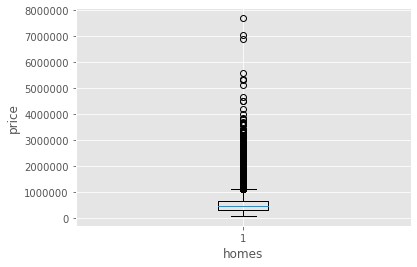

In [150]:
# investigate price outliers
plt.boxplot(data['price'])
plt.xlabel('homes')
plt.ylabel('price'); # looks like outliers are probably accurate

In [151]:
# look at highest price outliers

data_price_outliers = data.loc[data.price > 1200000].sort_values(by='price', ascending=False)
data_price_outliers.head(500)
data_price_outliers.describe()


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,978.00000,978.00000,978.00000,978.00000,978.00000,978.00000,978.00000,884.00000,974.00000,978.00000,978.00000,978.00000,978.00000,802.00000,978.00000,978.00000,978.00000,978.00000,978.00000
mean,4199005117.57566,1753916.15542,4.12577,3.30138,4023.02045,24002.03681,1.82771,0.09729,1.40862,3.48057,9.97648,3271.96115,1974.21779,261.68454,98066.95910,47.61714,-122.23040,3148.33538,18596.53681
std,2847716344.69515,669647.47377,0.91251,0.89536,1249.59547,62001.61640,0.49067,0.29651,1.57947,0.71548,1.17656,1161.49873,33.12874,674.64953,56.22089,0.05709,0.10513,851.13858,39444.94882
min,31000165.00000,1210000.00000,1.00000,1.00000,1590.00000,609.00000,1.00000,0.00000,0.00000,1.00000,7.00000,1230.00000,1900.00000,0.00000,98004.00000,47.32930,-122.45100,1100.00000,1229.00000
25%,1724069066.25000,1330000.00000,4.00000,2.50000,3180.00000,7226.75000,1.50000,0.00000,0.00000,3.00000,9.00000,2385.00000,1951.00000,0.00000,98008.00000,47.57868,-122.28975,2560.00000,6769.50000
50%,3630070230.00000,1550000.00000,4.00000,3.25000,3855.00000,11677.50000,2.00000,0.00000,0.00000,3.00000,10.00000,3105.00000,1985.00000,0.00000,98040.00000,47.62635,-122.22700,3075.00000,11116.00000
75%,6562150052.50000,1900000.00000,5.00000,3.75000,4578.75000,19448.50000,2.00000,0.00000,3.00000,4.00000,11.00000,3930.00000,2003.00000,0.00000,98112.00000,47.64660,-122.19600,3727.75000,17853.00000
max,9831200520.00000,7700000.00000,9.00000,8.00000,13540.00000,920423.00000,3.50000,1.00000,4.00000,5.00000,13.00000,9410.00000,2015.00000,2015.00000,98199.00000,47.77290,-121.75600,6210.00000,858132.00000


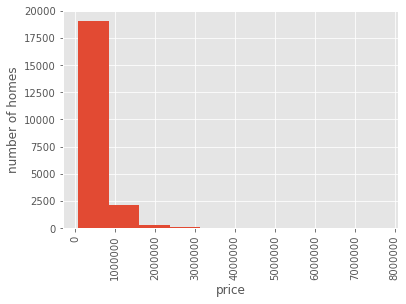

In [152]:
data['price'].hist(bins = 10)
plt.xticks(rotation = 'vertical')
plt.xlabel('price')
plt.ylabel('number of homes');

In both the box plot and the histogram above, prices look truly outlandish above $3.25 million.  There are 32 homes at or above this sale price, which I removed from the data below.

In [153]:
# how many homes sold at or above $3.25 million?
data['price'].loc[data['price'] >= 3250000].count() #32 homes

32

In [154]:
# drop rows with price > $3.25 million - cuts off the top 32 homes

data = data.loc[data['price'] < 3250000]

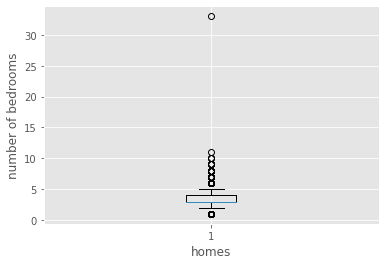

In [155]:
# looking at row detail, max values for price, bathrooms, sqft_living & sqft_above seem accurate
# what about bedrooms (33?) and sqft_lot
# investigate bedrooms outliers

plt.boxplot(data.bedrooms)
plt.xlabel('homes')
plt.ylabel('number of bedrooms'); # looks like there may be at least 1 inaccurate outlier

In [156]:
# investigate bedrooms outliers

data_br_outliers = data.loc[data.bedrooms > 5].sort_values(by='bedrooms', ascending=False)
data_br_outliers.head(20)

# looks like 33 bedrooms is an outlier due to small sqft_living and number of bathrooms

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,640000.00000,33,1.75000,1620,6000,1.00000,0.00000,0.00000,5,7,1040,580.0,1947,0.00000,98103,47.68780,-122.33100,1330,4700
8748,1773100755,8/21/2014,520000.00000,11,3.00000,3000,4960,2.00000,0.00000,0.00000,3,7,2400,600.0,1918,1999.00000,98106,47.55600,-122.36300,1420,4960
19239,8812401450,12/29/2014,660000.00000,10,3.00000,2920,3745,2.00000,0.00000,0.00000,4,7,1860,1060.0,1913,0.00000,98105,47.66350,-122.32000,1810,3745
13301,627300145,8/14/2014,1150000.00000,10,5.25000,4590,10920,1.00000,0.00000,2.00000,3,9,2500,2090.0,2008,0.00000,98004,47.58610,-122.11300,2730,10400
15147,5566100170,10/29/2014,650000.00000,10,2.00000,3610,11914,2.00000,0.00000,0.00000,4,7,3010,600.0,1958,0.00000,98006,47.57050,-122.17500,2040,11914
8537,424049043,8/11/2014,450000.00000,9,7.50000,4050,6504,2.00000,0.00000,0.00000,3,7,4050,0.0,1996,0.00000,98144,47.59230,-122.30100,1448,3866
16830,8823900290,3/17/2015,1400000.00000,9,4.00000,4620,5508,2.50000,0.00000,0.00000,3,11,3870,750.0,1915,0.00000,98105,47.66840,-122.30900,2710,4320
4092,1997200215,5/7/2014,599999.00000,9,4.50000,3830,6988,2.50000,0.00000,0.00000,3,7,2450,1380.0,1938,0.00000,98103,47.69270,-122.33800,1460,6291
4231,2902200015,1/6/2015,700000.00000,9,3.00000,3680,4400,2.00000,0.00000,0.00000,3,7,2830,850.0,1908,0.00000,98102,47.63740,-122.32400,1960,2450
18428,8823901445,3/13/2015,934000.00000,9,3.00000,2820,4480,2.00000,0.00000,0.00000,3,7,1880,940.0,1918,0.00000,98105,47.66540,-122.30700,2460,4400


In [157]:
# let's drop the row with 33 bedrooms

data = data.loc[data.bedrooms < 33]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21564 entries, 0 to 21596
Data columns (total 21 columns):
id               21564 non-null int64
date             21564 non-null object
price            21564 non-null float64
bedrooms         21564 non-null int64
bathrooms        21564 non-null float64
sqft_living      21564 non-null int64
sqft_lot         21564 non-null int64
floors           21564 non-null float64
waterfront       19188 non-null float64
view             21502 non-null float64
condition        21564 non-null int64
grade            21564 non-null int64
sqft_above       21564 non-null int64
sqft_basement    21564 non-null object
yr_built         21564 non-null int64
yr_renovated     17725 non-null float64
zipcode          21564 non-null int64
lat              21564 non-null float64
long             21564 non-null float64
sqft_living15    21564 non-null int64
sqft_lot15       21564 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.6+ MB


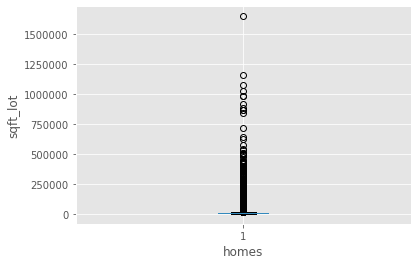

In [158]:
# investigate sqft_lot outliers

plt.boxplot(data.sqft_lot)
plt.xlabel('homes')
plt.ylabel('sqft_lot');

# hard to say if the max value is inaccurate, let's look at it

In [159]:
# investigate sqft_lot outliers

data_lot_outliers = data.loc[data.sqft_lot > 500000].sort_values(by='sqft_lot', ascending=False)
data_lot_outliers.head(500)

# looks accurate.  checked out the first 3 zip codes and they are rural areas
# do not drop these rows for now.  See if zip code segmentation helps.

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1717,1020069017,3/27/2015,700000.00000,4,1.00000,1300,1651359,1.00000,0.00000,3.00000,4,6,1300,0.0,1920,0.00000,98022,47.23130,-122.02300,2560,425581
17305,3326079016,5/4/2015,190000.00000,2,1.00000,710,1164794,1.00000,0.00000,0.00000,2,5,710,0.0,1915,0.00000,98014,47.68880,-121.90900,1680,16730
7640,2623069031,5/21/2014,542500.00000,5,3.25000,3010,1074218,1.50000,nan,0.00000,5,8,2010,1000.0,1931,0.00000,98027,47.45640,-122.00400,2450,68825
7762,2323089009,1/19/2015,855000.00000,4,3.50000,4030,1024068,2.00000,0.00000,0.00000,3,10,4030,0.0,2006,0.00000,98045,47.46190,-121.74400,1830,11700
3945,722069232,9/5/2014,998000.00000,4,3.25000,3770,982998,2.00000,0.00000,0.00000,3,10,3770,0.0,1992,0.00000,98058,47.41400,-122.08700,2290,37141
4437,3626079040,7/30/2014,790000.00000,2,3.00000,2560,982278,1.00000,0.00000,0.00000,3,8,2560,0.0,2004,0.00000,98014,47.69550,-121.86100,1620,40946
6685,2624089007,3/20/2015,2000000.00000,2,2.50000,3900,920423,2.00000,0.00000,0.00000,3,12,3900,0.0,2009,0.00000,98065,47.53710,-121.75600,2720,411962
7070,2724079090,1/5/2015,1650000.00000,4,3.25000,3920,881654,3.00000,nan,3.00000,3,11,3920,?,2002,nan,98024,47.53850,-121.89600,2970,112384
9705,225079036,1/7/2015,937500.00000,4,4.00000,5545,871200,2.00000,0.00000,0.00000,3,11,3605,1940.0,2003,0.00000,98014,47.67600,-121.88200,3420,871200
20436,1125079111,4/15/2015,1600000.00000,4,5.50000,6530,871200,2.00000,0.00000,2.00000,3,11,6530,0.0,2008,0.00000,98014,47.66400,-121.87800,1280,858132


### Null values

Four columns had null values: 'waterfront', 'yr_renovated', 'sqft_basement', and 'view'.  Since fewer than 1% of properties were marked as having waterfront views, I dropped this column from the analysis.  I replaced 'yr_renovated' with a binary column showing whether or not the home was marked renovated in any year.  I replaced the null values in 'sqft_basement' (which appeared as ? in the data) with zeros, since the median of the non-null values in this column was also zero.  Since 'view' refers to the number of times a house had been viewed (not whether it has a nice view), I dropped this column from the analysis.

In [160]:
# investigate null values in waterfront

data.waterfront.value_counts() # binary - 1 or 0
data.waterfront.isna().sum() #2376 null values out of 21596
data.waterfront.value_counts() 

# I'm reluctant to drop the rows, which are > 10% of the data
# Only 131 homes are marked as waterfront -- less than 1% of data
# So I'll drop this feature from the analysis

0.00000    19057
1.00000      131
Name: waterfront, dtype: int64

In [161]:
# deal with null values in yr_renovated

data['yr_renovated'].value_counts().head(50)
# 16987 values are 0 (meaning no true value)

nulls = data['yr_renovated'].isna().sum() 
nulls #3839 values are null

# many of the values with years are old, e.g. 1930's-1990's

3839

In [162]:
# create a new column showing homes renovated or not

data['renovated'] = np.where(data['yr_renovated'] > 0, 1, 0)
data['renovated'].value_counts() # only 738 homes show a year renovated

0    20826
1      738
Name: renovated, dtype: int64

In [163]:
# deal with non-number values in sqft_basement
data['sqft_basement'].value_counts() # continuous variable, but has 454 '?' values
# also 12826 0 values.  Not sure if these homes truly do not have basements.

# per cent of data that is missing:
missing_sqft_basement = round((len(data.loc[data['sqft_basement'] == '?'])/len(data))*100, 2)
print(missing_sqft_basement, "% of basement data is missing")

# per cent of data that is zero:
missing_sqft_basement = round((len(data.loc[data['sqft_basement'] == '0.0'])/len(data))*100, 2)
print(missing_sqft_basement, "% of basement data is zero")

2.1 % of basement data is missing
59.46 % of basement data is zero


In [164]:
# for now, let's fill missing values with zero, since that's the median

#replace all '?' values with '0'
data.loc[data['sqft_basement'] == '?', 'sqft_basement'] = '0'

data['sqft_basement'].value_counts().head(20)

0.0       12821
0           453
600.0       216
500.0       209
700.0       208
800.0       201
400.0       184
1000.0      148
900.0       142
300.0       142
200.0       105
750.0       104
480.0       103
450.0       103
530.0       103
720.0        98
620.0        90
840.0        83
580.0        83
420.0        81
Name: sqft_basement, dtype: int64

In [165]:
# now convert sqft_basement values to integers

data['sqft_basement'] = pd.to_numeric(data['sqft_basement'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21564 entries, 0 to 21596
Data columns (total 22 columns):
id               21564 non-null int64
date             21564 non-null object
price            21564 non-null float64
bedrooms         21564 non-null int64
bathrooms        21564 non-null float64
sqft_living      21564 non-null int64
sqft_lot         21564 non-null int64
floors           21564 non-null float64
waterfront       19188 non-null float64
view             21502 non-null float64
condition        21564 non-null int64
grade            21564 non-null int64
sqft_above       21564 non-null int64
sqft_basement    21564 non-null float64
yr_built         21564 non-null int64
yr_renovated     17725 non-null float64
zipcode          21564 non-null int64
lat              21564 non-null float64
long             21564 non-null float64
sqft_living15    21564 non-null int64
sqft_lot15       21564 non-null int64
renovated        21564 non-null int64
dtypes: float64(9), int64(12), objec

### Exploring Correlations

The analysis below shows that the strongest correlations with price (the target variable) are sqft_living, sqft_above, sqft_living15, grade, and bathrooms.
The strongest correlations between X variables are among these same columns -- all five are correlated with each other.  This multicolinearity could negatively impact a prediction model, so I will experiment with dropping combinations of multicolinear columns later on.
Of all the variables, only grade and bedrooms look normally distributed.  Most are right-skewed, including price.  Later, I will see if log transformations on these variables improve the model.

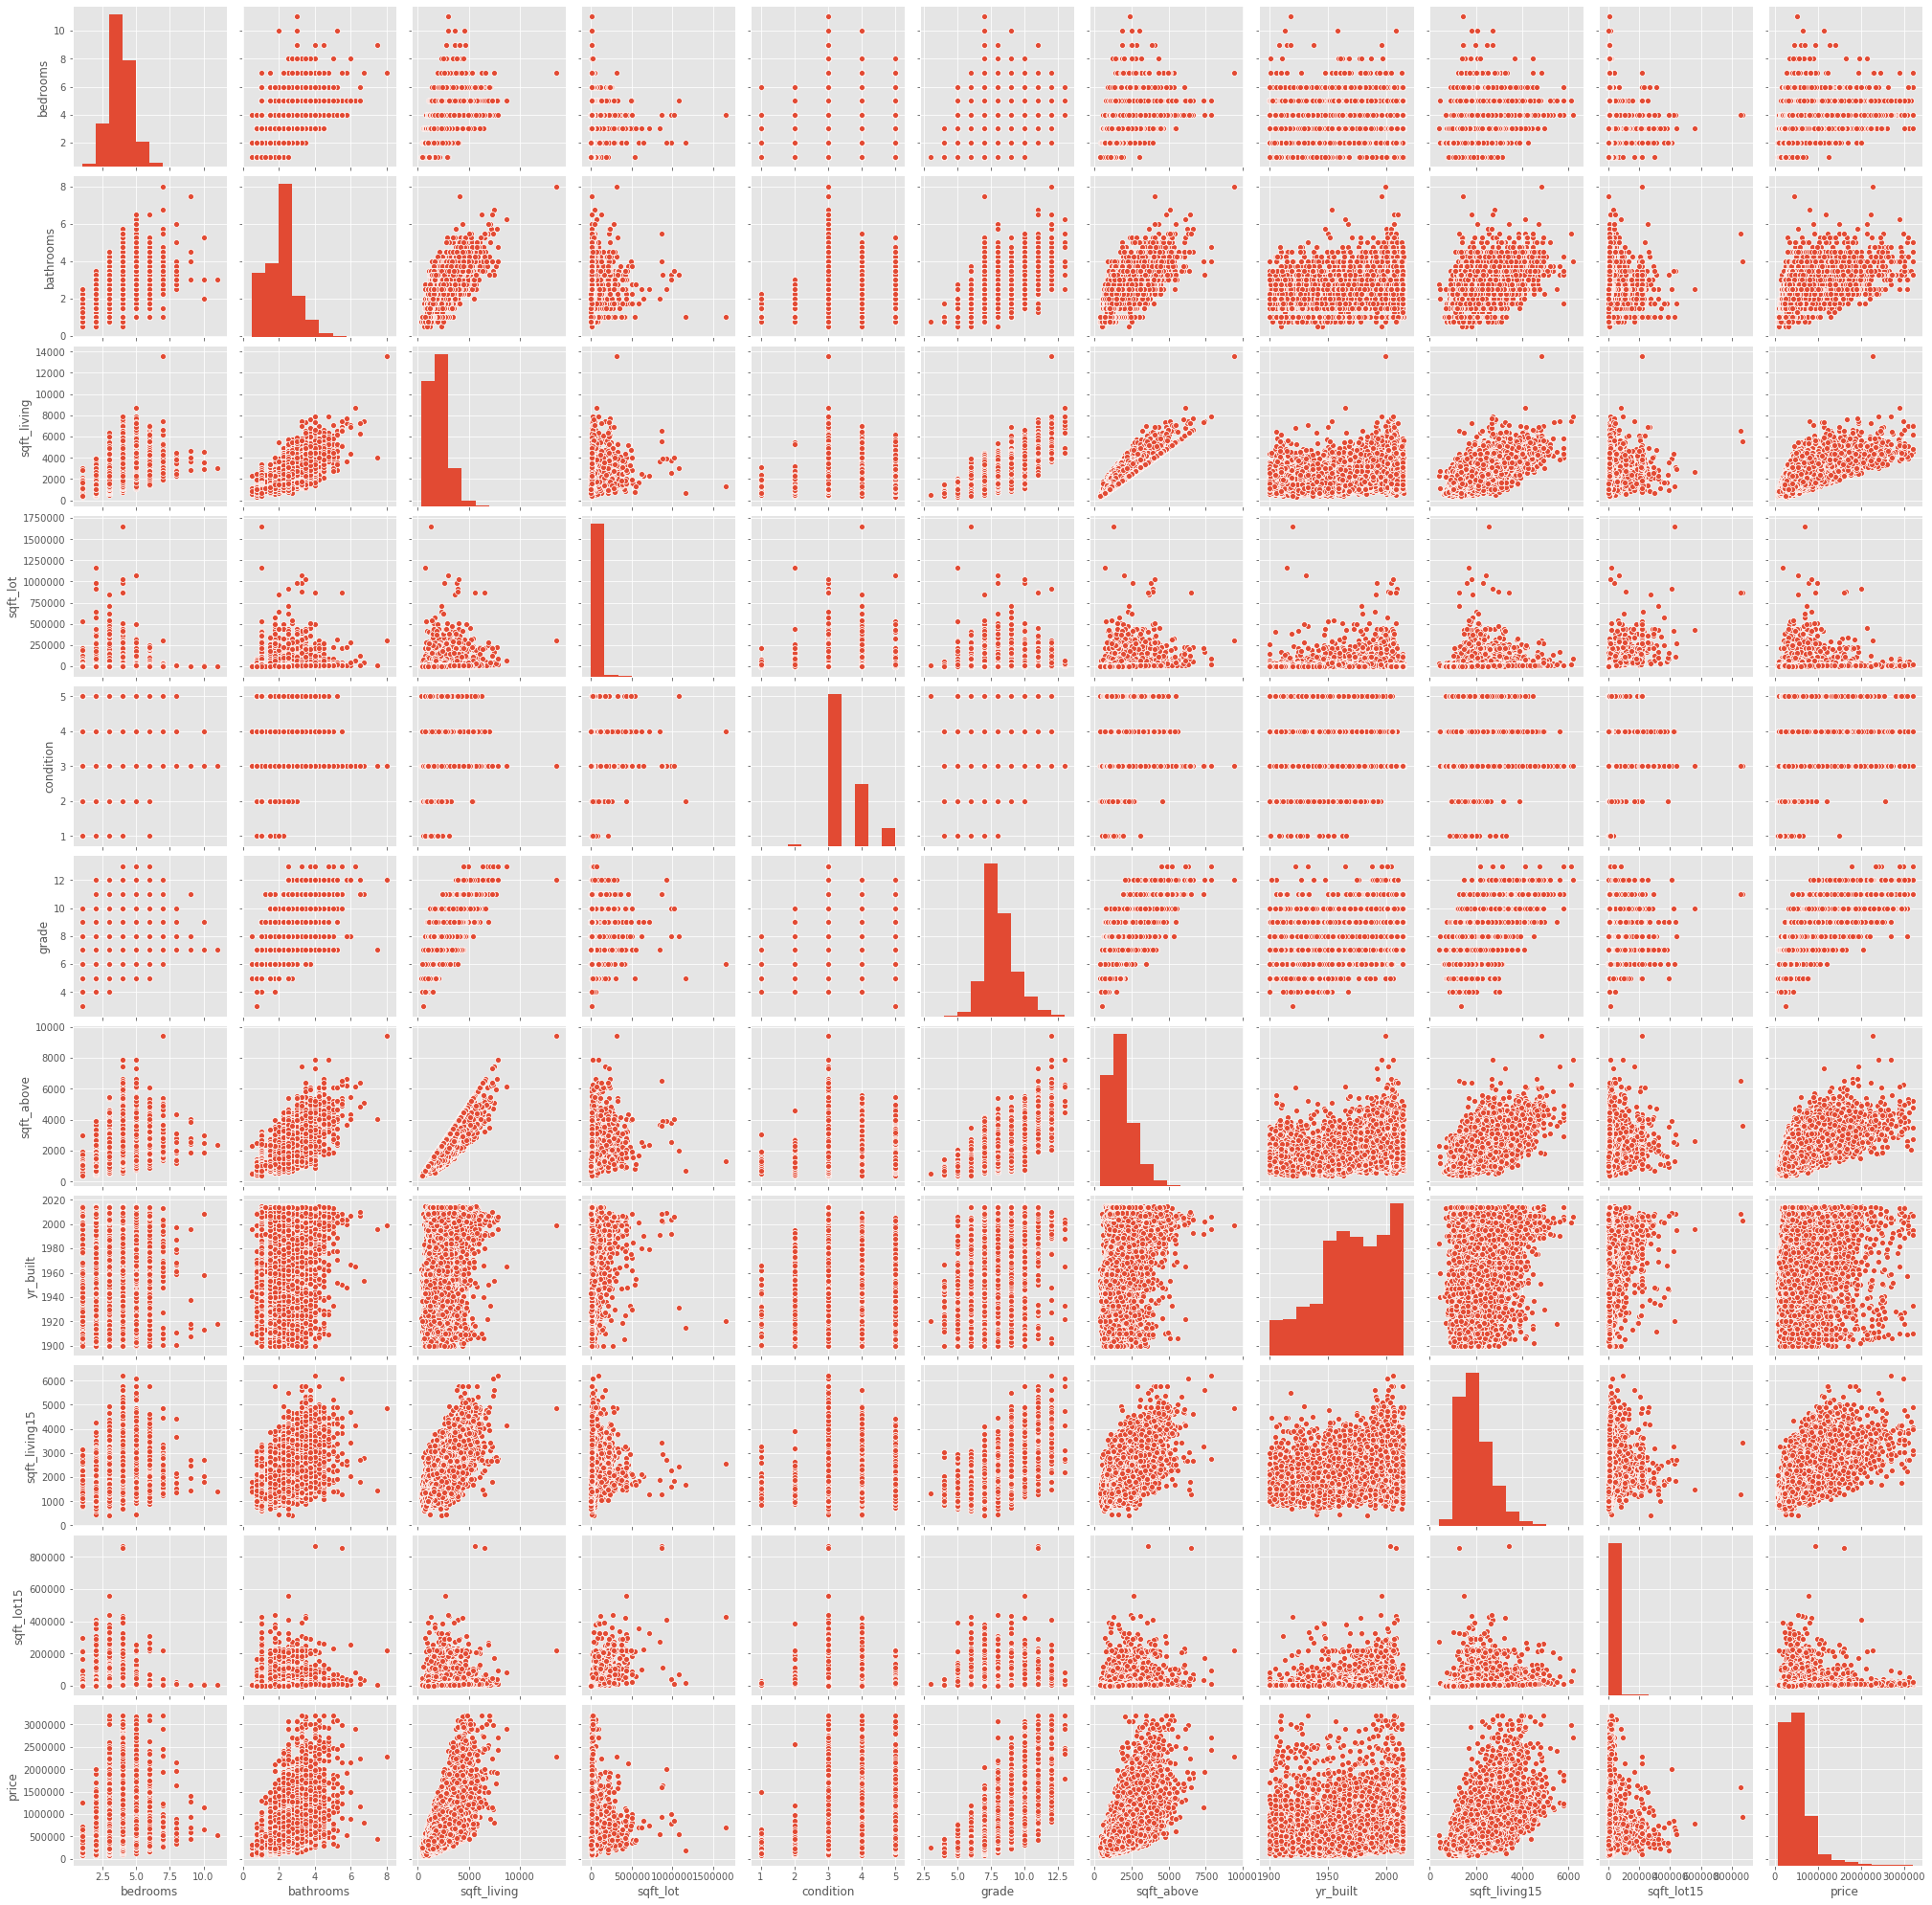

In [166]:
# explore data
# let's try a pairplot to see if anything stands out

cols_of_interest = [ 
                    'bedrooms', 
                    'bathrooms', 
                    'sqft_living',
                    'sqft_lot', 
                    'condition', 
                    'grade', 
                    'sqft_above',
                    'yr_built',  
                    'sqft_living15', 
                    'sqft_lot15',
                    'price']

sns.pairplot(data[cols_of_interest]);

# the strongest correlations with price are sqft_living, sqft_above, sqft_living15, grade, and bathrooms
# strongest correlations between X variables are among these same columns
# only grade and bedrooms look normally distributed

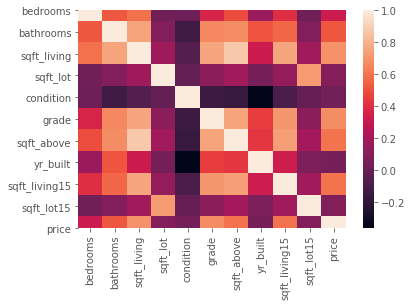

In [167]:
# let's make a heatmap to be sure

sns.heatmap(data[cols_of_interest].corr())

# yes, confirms the observations above

In [168]:
# let's look at the numbers

data[cols_of_interest].corr()

# sqft_living is the best predictor of price so far

,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,price
bedrooms,1.00000,0.52601,0.59550,0.03324,0.02291,0.36274,0.49110,0.16098,0.40191,0.03148,0.32098
bathrooms,0.52601,1.00000,0.75111,0.08812,-0.12757,0.66079,0.68042,0.51117,0.56559,0.08776,0.51926
sqft_living,0.59550,0.75111,1.00000,0.17553,-0.06030,0.75986,0.87360,0.32302,0.75738,0.18639,0.69234
sqft_lot,0.03324,0.08812,0.17553,1.00000,-0.00878,0.11454,0.18550,0.05287,0.14470,0.71818,0.09421
condition,0.02291,-0.12757,-0.06030,-0.00878,1.00000,-0.14805,-0.16079,-0.36130,-0.09354,-0.00298,0.04077
grade,0.36274,0.66079,0.75986,0.11454,-0.14805,1.00000,0.75274,0.45000,0.71092,0.12056,0.68030
sqft_above,0.49110,0.68042,0.87360,0.18550,-0.16079,0.75274,1.00000,0.42848,0.73065,0.19629,0.59759
yr_built,0.16098,0.51117,0.32302,0.05287,-0.36130,0.45000,0.42848,1.00000,0.32708,0.07058,0.05322
sqft_living15,0.40191,0.56559,0.75738,0.14470,-0.09354,0.71092,0.73065,0.32708,1.00000,0.18341,0.60035
sqft_lot15,0.03148,0.08776,0.18639,0.71818,-0.00298,0.12056,0.19629,0.07058,0.18341,1.00000,0.08560


In [169]:
# let's look just at the correlations with price

data[cols_of_interest].corr()['price'].sort_values(ascending=False)

# interesting, sqft_living and grade are far above the rest
# grade is probably based in part on sqft_living

price           1.00000
sqft_living     0.69234
grade           0.68030
sqft_living15   0.60035
sqft_above      0.59759
bathrooms       0.51926
bedrooms        0.32098
sqft_lot        0.09421
sqft_lot15      0.08560
yr_built        0.05322
condition       0.04077
Name: price, dtype: float64

### Column Exclusion
Based on the analyses above, I decided to exclude the following columns from the model.  Justifications are provided below:

* id - the randomly assigned house id
* date - date sold, all are between May 2014 and May 2015.  May investigate impact of month later
* waterfront - less than 1% of homes marked as waterfront
* view - number of times the home has been viewed - not relevant for pricing homes newly on the market
* yr_renovated - missing values.  Turned into binary column 'renovated'
* 'lat' and 'long' - latitude and longitude of house - easier to pull location info with zipcode

## Modeling

In this section, I tested different models after splitting the data into training and test sets using a 70/30 split.  I first calculated a model-less baseline with an R-squared of 0 and a Mean Absolute Error of \\$230K.  I then tested a baseline linear regression model without transforming any features of the data.  This produced an R-squared of 0.63 for both the training and test sets, and Mean Absolute Errors of \\$138K and \\$136K respectively. \
\
After experimenting with log-transforming the X variables and the target variable price, I was able to improve the metrics by log-transforming price, sqft_living15, and sqft_lot15.  By assigning zip codes to price-based classifications, I improved the R-squared to 0.83 for the training data and 0.82 for the test data, with Mean Absolute Errors of \\$90K and \\$87K respectively. \
\
I also tested other strategies, such as reducing multicolinearity by dropping columns, omitting features with high p-values, and assigning the yr_built data to categories.  None of these changes improved the model.  However, omitting features with high p-values did not change the model at all, so I kept this change in order to simplify the model.

In [170]:
# split data into test and training sets

# choose relevant columns:

X=data[['bedrooms', 
       'bathrooms', 
       'sqft_living', 
       'sqft_lot', 
       'floors', 
       'condition', 
       'grade',
       'sqft_above', 
       'sqft_basement', 
       'yr_built', 
       'zipcode',
       'sqft_living15', 
       'sqft_lot15', 
       'renovated']]

y=data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(len(X_train), len(X_test), len(y_train), len(y_test))

15094 6470 15094 6470


### Model 1: Model-less Baseline

In [171]:
# for our first model-less baseline, let's use the mean price
# start with training set

mean_price = y_train.mean()
y_pred_train = np.full(shape=(len(X_train), 1), fill_value=mean_price)

# check r2
r2_baseline_train = round(r2_score(y_true=y_train, y_pred=y_pred_train), 6)

# check Mean Absolute Error
mae_baseline_train = round(mean_absolute_error(y_true=y_train, y_pred=y_pred_train), 2)

# check Root Mean Squared Error
rmse_baseline_train = round(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train)), 2)

print('Training Data', '\n', 
      'Mean Price:', round(mean_price, 2), '\n', 
      'R-Squared:', r2_baseline_train, '\n',
      'Mean Absolute Error:', mae_baseline_train, '\n',
      'Root Mean Squared Error:', rmse_baseline_train)

Training Data 
 Mean Price: 537250.03 
 R-Squared: 0.0 
 Mean Absolute Error: 229795.19 
 Root Mean Squared Error: 340631.29


In [172]:
# now let's calculate baseline r2, MAE, and RMSE for the test set

y_pred_test = np.full(shape=(len(X_test), 1), fill_value=mean_price)

r2_baseline_test = round(r2_score(y_true=y_test, y_pred=y_pred_test), 6)
mae_baseline_test = round(mean_absolute_error(y_true=y_test, y_pred=y_pred_test), 2)
rmse_baseline_test = round(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test)), 2)

print('Testing Data', '\n', 
      'Mean Price:', round(mean_price, 2), '\n', 
      'R-Squared:', r2_baseline_test, '\n',
      'Mean Absolute Error:', mae_baseline_test, '\n',
      'Root Mean Squared Error:', rmse_baseline_test)

Testing Data 
 Mean Price: 537250.03 
 R-Squared: -0.000618 
 Mean Absolute Error: 224221.98 
 Root Mean Squared Error: 325342.64


In [173]:
# create a function for evaluating models:

def evaluate_model(y_train, y_train_pred, y_test, y_test_pred):

    # check train r2
    r2_train = round(r2_score(y_true=y_train, y_pred=y_train_pred), 6)

    # check train Mean Absolute Error
    mae_train = round(mean_absolute_error(y_true=y_train, y_pred=y_train_pred), 2)

    # check train Root Mean Squared Error
    rmse_train = round(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_train_pred)), 2)

    print('Training Data', '\n', 
          'R-Squared:', r2_train, '\n',
          'Mean Absolute Error:', mae_train, '\n',
          'Root Mean Squared Error:', rmse_train, '\n')
    
    # check test r2
    r2_test = round(r2_score(y_true=y_test, y_pred=y_test_pred), 6)

    # check test Mean Absolute Error
    mae_test = round(mean_absolute_error(y_true=y_test, y_pred=y_test_pred), 2)

    # check train Root Mean Squared Error
    rmse_test = round(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_test_pred)), 2)

    print('Testing Data', '\n', 
          'R-Squared:', r2_test, '\n',
          'Mean Absolute Error:', mae_test, '\n',
          'Root Mean Squared Error:', rmse_test)

In [174]:
# the mean is not a good predictor of price!

# let's fit a baseline regression model

### Model 2: Baseline Linear Regression

In [175]:
# first, let's scale the data so we can evaluate the coefficients of the baseline model

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [176]:
# now do a linear regression

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

y_train_pred2 = linreg.predict(X_train_scaled)
y_test_pred2 = linreg.predict(X_test_scaled)

evaluate_model(y_train, y_train_pred2, y_test, y_test_pred2)

Training Data 
 R-Squared: 0.63127 
 Mean Absolute Error: 138015.86 
 Root Mean Squared Error: 206841.99 

Testing Data 
 R-Squared: 0.628868 
 Mean Absolute Error: 136007.71 
 Root Mean Squared Error: 198139.37


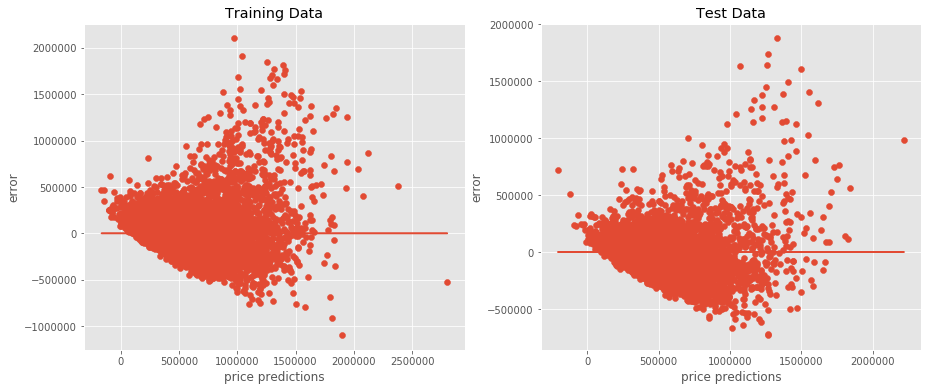

In [177]:
# that's better, but the model still only explains about 60% of the variance
# let's plot training set residuals

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15,6))

residuals_train = y_train-y_train_pred2
ax1 = plt.subplot(121)
ax1.scatter(y_train_pred2, residuals_train)
ax1.plot(y_train_pred2, [0 for i in range(len(y_train_pred2))])
plt.title('Training Data')
plt.xlabel('price predictions')
plt.ylabel('error')

residuals_test = y_test-y_test_pred2
ax2 = plt.subplot(122)
ax2.scatter(y_test_pred2, residuals_test)
ax2.plot(y_test_pred2, [0 for i in range(len(y_test_pred2))])
plt.title('Test Data')
plt.xlabel('price predictions')
plt.ylabel('error');

# cone-shaped residuals indicate heteroskedasticity
# means that as price increases, error increases as well
# will try log transformations to reduce the effect of outliers

In [178]:
# run it in Statsmodels to check coefficients

model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)))
results = model.fit()

results.summary()

# same R-squared as above
# sqft_lot and sqft_above have p-values above 0.05.  Experiment with removing these later

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     1844.
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        10:41:07   Log-Likelihood:            -2.0616e+05
No. Observations:               15094   AIC:                         4.124e+05
Df Residuals:                   15079   BIC:                         4.125e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.373e+05   1684.428    318.951      0.000    5.34e+05    5.41e+05
bedrooms       -3.58e+04   2198.244    -16.285      0.000   -4.01e+04   -3.15e+04
bathrooms      3.329e+04   3063.575     10.868      0.000    2.73e+04    3.93e+04
sqft_living    9.965e+04    2.1e+04      4.737      0.000    5.84e+04    1.41e+05
sqft_lot       1697.7574   2453.650      0.692      0.489   -3111.694    6507.209
floors         2.361e+04   2375.073      9.939      0.000     1.9e+04    2.83e+04
condition      1.621e+04   1870.545      8.667      0.000    1.25e+04    1.99e+04
grade          1.504e+05   3018.925     49.832      0.000    1.45e+05    1.56e+05
sqft_above     7397.5212    1.9e+04      0.389      0.697   -2.98e+04    4.46e+04
sqft_basement  2.245e+04   1.01e+04      2.229      0.026    2710.971    4.22e+04
yr_built      -1.086e+05   2463.032    -44.096      0.000   -1.13e+05   -1.04e+05
zipcode        6448.7556   1912.926      3.371      0.001    2699.188    1.02e+04
sqft_living15  4.165e+04   2846.025     14.635      0.000    3.61e+04    4.72e+04
sqft_lot15    -1.076e+04   2462.989     -4.369      0.000   -1.56e+04   -5932.446
renovated      7604.2525   1762.209      4.315      0.000    4150.109    1.11e+04
==============================================================================
Omnibus:                     7616.012   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           102533.628
Skew:                           2.100   Prob(JB):                         0.00
Kurtosis:                      15.058   Cond. No.                         39.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 3: 7 Log-Transformed X Variables

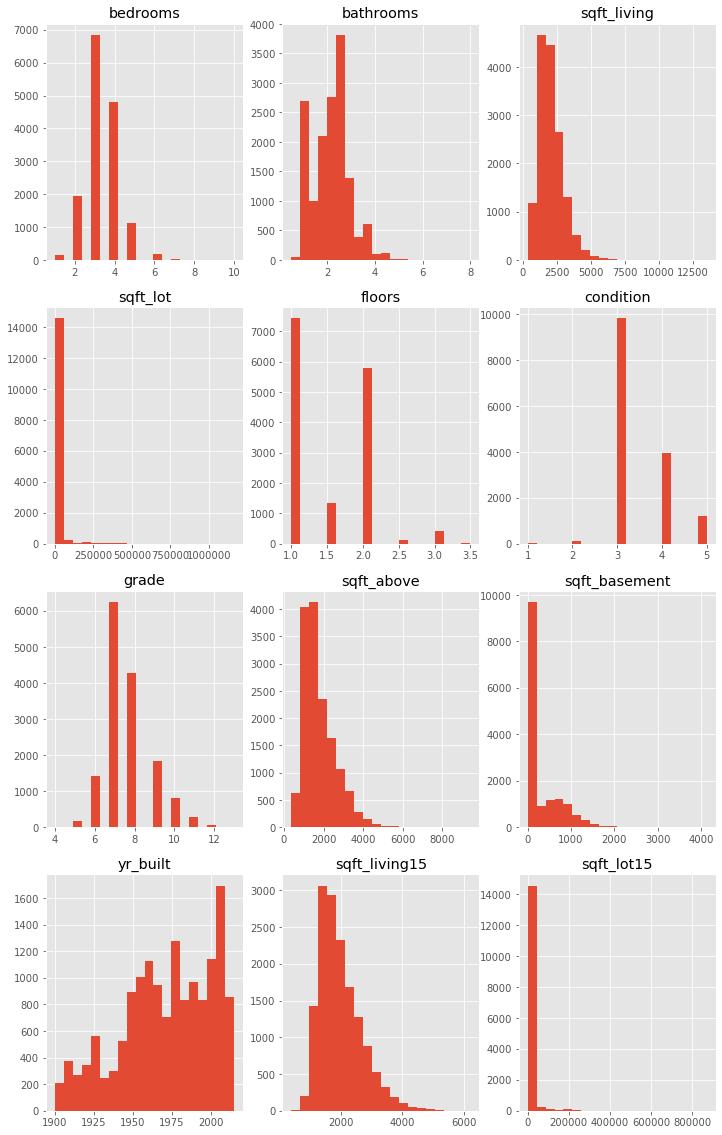

In [179]:
# let's look at the numeric variables.  Are they normally distributed?

numeric = ['bedrooms', 
       'bathrooms', 
       'sqft_living', 
       'sqft_lot', 
       'floors', 
       'condition', 
       'grade',
       'sqft_above', 
       'sqft_basement', 
       'yr_built',
       'sqft_living15', 
       'sqft_lot15'
             ]

num_cols = 3
if len(numeric)%num_cols == 0:
    num_rows = len(numeric)//num_cols
else:
    num_rows = (len(numeric)//num_cols)+1


fig, axs = plt.subplots(figsize=(12,20), nrows=num_rows, ncols=num_cols)


for feat in numeric:
    axs[numeric.index(feat)//num_cols, numeric.index(feat)%num_cols].hist(X_train[feat], bins=20)
    axs[numeric.index(feat)//num_cols, numeric.index(feat)%num_cols].set_title(feat)

In [180]:
# numeric variables are not normally distributed
# let's try to log these and see if they become more normal
# don't include features with zeros, like sqft_basement

non_zero = ['bedrooms', 
       'bathrooms', 
       'sqft_living', 
       'sqft_lot', 
       'floors', 
       'condition', 
       'grade',
       'sqft_above', 
       'yr_built',
       'sqft_living15', 
       'sqft_lot15'
             ]

X_train_logged = X_train.copy()

for feat in non_zero:
    X_train_logged[feat] = X_train_logged[feat].map(lambda x: np.log(x))


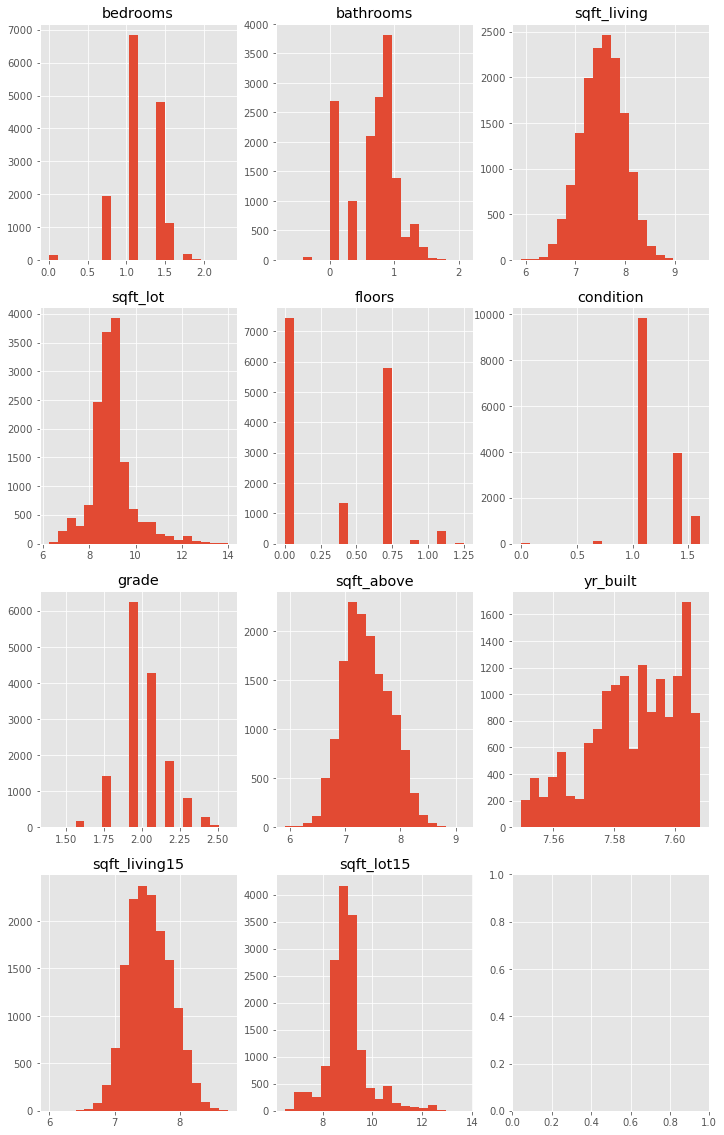

In [181]:
# Did it help?  Make more histograms

num_cols = 3
if len(non_zero)%num_cols == 0:
    num_rows = len(non_zero)//num_cols
else:
    num_rows = (len(non_zero)//num_cols)+1


fig, axs = plt.subplots(figsize=(12,20), nrows=num_rows, ncols=num_cols)


for feat in non_zero:
    axs[non_zero.index(feat)//num_cols, non_zero.index(feat)%num_cols].hist(X_train_logged[feat], bins=20)
    axs[non_zero.index(feat)//num_cols, non_zero.index(feat)%num_cols].set_title(feat)

In [182]:
# it helped - some variables look more normally distributed
# like sqft_living, sqft_lot, grade, sqft_above, sqft_living15, sqft_lot15
# and to a lesser extent, bedrooms and grade too

In [183]:
# what if we build a model with just the above columns logged

# build a new X_train with just the above features logged

to_log = ['bedrooms', 
       'sqft_living', 
       'sqft_lot', 
       'grade',
       'sqft_above', 
       'sqft_living15', 
       'sqft_lot15'
             ]

X_train3 = X_train.copy()

for feat in to_log:
    X_train3[feat] = X_train3[feat].map(lambda x: np.log(x))
    
# log the test data

X_test3 = X_test.copy()

for feat in to_log:
    X_test3[feat] = X_test3[feat].map(lambda x: np.log(x))

In [184]:
# build a function to scale the X variables, and do a linear regression

def scale_lin_reg(X_train, y_train, X_test):
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    linreg = LinearRegression()
    linreg.fit(X_train_scaled, y_train)

    y_train_pred = linreg.predict(X_train_scaled)
    y_test_pred = linreg.predict(X_test_scaled)
        
    return(y_train_pred, y_test_pred)

In [185]:
# let's scale and do a linear regression on the transformed data, to return y_train_pred and y_test_pred
# the inputs X_train3 and X_test3 have 7 features logged

y_train_pred3, y_test_pred3 = scale_lin_reg(X_train=X_train3, y_train=y_train, X_test=X_test3)

In [186]:
# now let's evaluate that model
evaluate_model(y_train=y_train, y_train_pred=y_train_pred3, y_test=y_test, y_test_pred=y_test_pred3)

Training Data 
 R-Squared: 0.600123 
 Mean Absolute Error: 143571.31 
 Root Mean Squared Error: 215401.12 

Testing Data 
 R-Squared: 0.591312 
 Mean Absolute Error: 141465.68 
 Root Mean Squared Error: 207923.01


In [187]:
# oh no!  It didn't help!  All three metrics got a little worse

### Model 4: 2 Logged X Variables

In [188]:
# these two features have the most improvement in normality after log transformations:
# sqft_living15
# sqft_lot15

# what if we just log these?

to_log = [
       'sqft_living15', 
       'sqft_lot15'
             ]

X_train4 = X_train.copy()

for feat in to_log:
    X_train4[feat] = X_train4[feat].map(lambda x: np.log(x))

# log the test data

X_test4 = X_test.copy()

for feat in to_log:
    X_test4[feat] = X_test4[feat].map(lambda x: np.log(x))

In [189]:
# let's scale and do a linear regression on the transformed data, to return y_train_pred and y_test_pred
# the inputs X_train4 and X_test4 have 2 features logged

y_train_pred4, y_test_pred4 = scale_lin_reg(X_train=X_train4, y_train=y_train, X_test=X_test4)

In [190]:
# evaluate the model

evaluate_model(y_train=y_train, y_train_pred=y_train_pred4, y_test=y_test, y_test_pred=y_test_pred4)

# That is a very slight improvement over the baseline model
# Price (target variable) was also right-skewed.  Let's try logging this as well.

Training Data 
 R-Squared: 0.631542 
 Mean Absolute Error: 137340.68 
 Root Mean Squared Error: 206765.81 

Testing Data 
 R-Squared: 0.630779 
 Mean Absolute Error: 135352.0 
 Root Mean Squared Error: 197628.55


### Model 5: Two Logged X Variables and Logged Target Variable

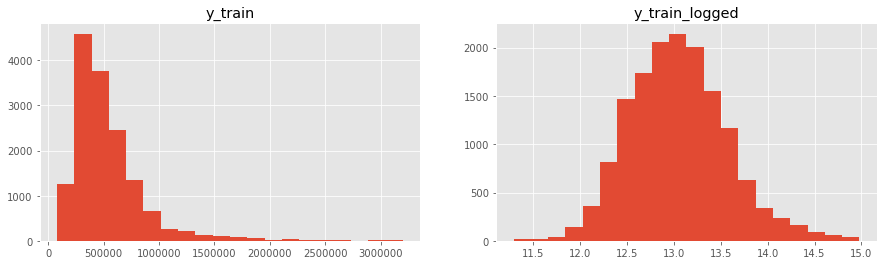

In [191]:
y_train_logged = y_train.copy()
y_train_logged = y_train_logged.map(lambda y: np.log1p(y))

fig, ax = plt.subplots(figsize = (15,4), nrows=1, ncols=2)

ax[0].hist(y_train, bins=20)
ax[0].set_title('y_train')

ax[1].hist(y_train_logged, bins=20)
ax[1].set_title('y_train_logged');

# the logged y_train definitely looks more normally distributed

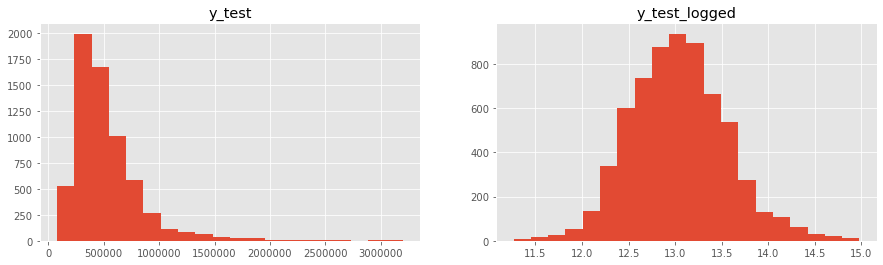

In [192]:
# log y_test as well

y_test_logged = y_test.copy()
y_test_logged = y_test_logged.map(lambda y: np.log1p(y))

fig, ax = plt.subplots(figsize = (15,4), nrows=1, ncols=2)

ax[0].hist(y_test, bins=20)
ax[0].set_title('y_test')

ax[1].hist(y_test_logged, bins=20)
ax[1].set_title('y_test_logged');

# the logged y_test looks more normally distributed too

In [193]:
# now let's run and evaluate the model with X_train4, X_test4, y_train_logged and y_test_logged

y_train_pred5, y_test_pred5 = scale_lin_reg(X_train=X_train4, y_train=y_train_logged, X_test=X_test4)

In [194]:
# create a function to only evaluate R-squared, since MAE and RMSE must use unlogged price predictions

def eval_r2(y_train, y_train_pred, y_test, y_test_pred):

    # calculate r2 using logged target variable
    r2_train = round(r2_score(y_true=y_train, y_pred=y_train_pred), 6)
    r2_test = round(r2_score(y_true=y_test, y_pred=y_test_pred), 6)

    print('Training Data', '\n', 
          'R-Squared:', r2_train, '\n')
    
    print('Test Data', '\n', 
          'R-Squared:', r2_test)

In [195]:
eval_r2(y_train=y_train_logged, y_train_pred=y_train_pred5, y_test=y_test_logged, y_test_pred=y_test_pred5)

Training Data 
 R-Squared: 0.654136 

Test Data 
 R-Squared: 0.642119


In [196]:
# great, it helped a little, but need to unlog y_train_pred5 and y_test_pred5 to measure price errors

# create a function to unlog predictions and measure MAE and RMSE
def unlog_MAE_RMSE(y_train, y_train_logged_pred, y_test, y_test_logged_pred):
    
    # unlog target variable predictions to measure MAE and RMSE
    y_train_pred_exp = np.expm1(y_train_logged_pred)
    y_test_pred_exp = np.expm1(y_test_logged_pred)
    
    # check Mean Absolute Error
    mae_train = round(mean_absolute_error(y_true=y_train, y_pred=y_train_pred_exp), 2)
    mae_test = round(mean_absolute_error(y_true=y_test, y_pred=y_test_pred_exp), 2)

    # check Root Mean Squared Error
    rmse_train = round(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_train_pred_exp)), 2)
    rmse_test = round(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_test_pred_exp)), 2)

    print('Training Data', '\n', 
          'Mean Absolute Error:', mae_train, '\n',
          'Root Mean Squared Error:', rmse_train, '\n')
    
    print('Test Data', '\n', 
          'Mean Absolute Error:', mae_test, '\n',
          'Root Mean Squared Error:', rmse_test, '\n')

In [197]:
unlog_MAE_RMSE(y_train=y_train, y_train_logged_pred=y_train_pred5, y_test=y_test, y_test_logged_pred=y_test_pred5)

Training Data 
 Mean Absolute Error: 129432.75 
 Root Mean Squared Error: 214795.91 

Test Data 
 Mean Absolute Error: 126991.03 
 Root Mean Squared Error: 193487.32 



### Model 6: Two Logged X Variables, Logged Target Variable, and Zip Code Categories

In [198]:
# let's try to assign zip codes to price categories

X_train6 = X_train4.copy() # use X_train4, which had two features logged

X_train6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15094 entries, 14289 to 15818
Data columns (total 14 columns):
bedrooms         15094 non-null int64
bathrooms        15094 non-null float64
sqft_living      15094 non-null int64
sqft_lot         15094 non-null int64
floors           15094 non-null float64
condition        15094 non-null int64
grade            15094 non-null int64
sqft_above       15094 non-null int64
sqft_basement    15094 non-null float64
yr_built         15094 non-null int64
zipcode          15094 non-null int64
sqft_living15    15094 non-null float64
sqft_lot15       15094 non-null float64
renovated        15094 non-null int64
dtypes: float64(5), int64(9)
memory usage: 1.7 MB


In [199]:
X_train6['zipcode'].value_counts().count() # 70 different zips
X_train6['zipcode'].value_counts()

98103    416
98052    414
98115    412
98038    405
98042    386
98034    382
98117    382
98006    363
98118    350
98023    348
98133    341
98059    328
98058    324
98074    314
98033    308
98155    306
98125    292
98053    291
98056    285
98027    277
98092    260
98001    258
98075    254
98126    244
98144    239
98116    234
98106    232
98004    231
98029    228
98199    228
98065    221
98122    210
98003    203
98146    200
98168    196
98055    195
98112    194
98072    193
98008    191
98178    188
98198    188
98031    187
98028    184
98040    180
98136    178
98177    176
98107    173
98030    167
98166    160
98105    159
98022    157
98045    152
98011    144
98077    132
98119    132
98002    132
98019    128
98108    127
98005    111
98007     98
98188     92
98014     89
98032     84
98070     80
98109     80
98010     74
98102     71
98024     61
98148     42
98039     33
Name: zipcode, dtype: int64

In [200]:
zips=pd.concat([X_train6['zipcode'], pd.DataFrame(y_train)['price']], axis=1)
zips

,zipcode,price
14289,98178,223000.00000
1078,98133,325000.00000
14957,98105,1020000.00000
2179,98004,1550000.00000
4133,98144,399950.00000
...,...,...
11303,98028,490000.00000
11983,98118,175000.00000
5400,98055,365000.00000
860,98168,245000.00000


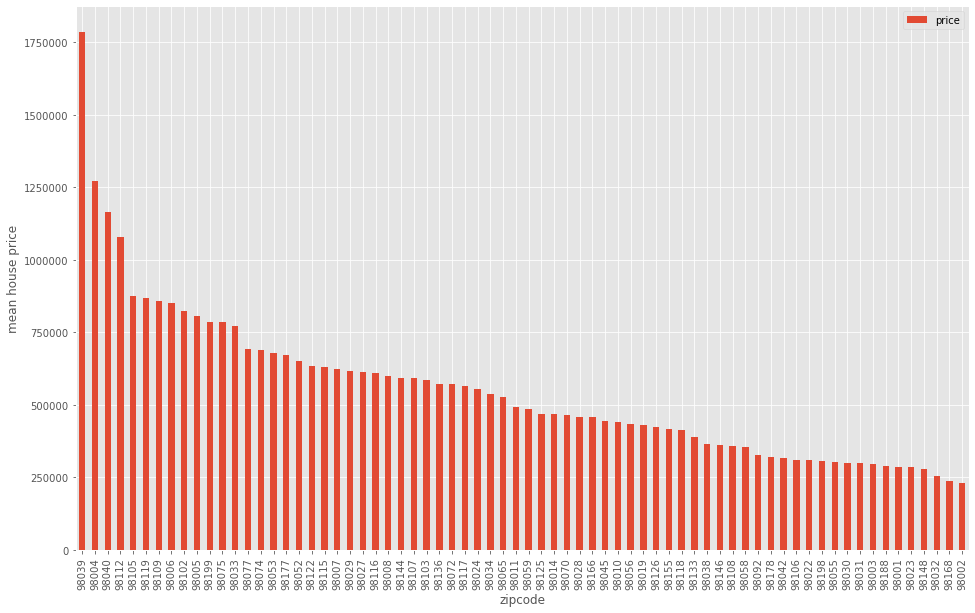

In [201]:
# find mean price by zip to see if any stand out

zips_pivot = zips.pivot_table(values='price', index='zipcode', ).sort_values(by='price', ascending=False)
zips_pivot.plot(kind='bar', figsize=(16,10))
plt.ylabel('mean house price')
plt.legend;
# yes, some do stand out!  the top four, the bottom three
# what if I classified them based on price? I can make a dictionary

In [202]:
# create a dictionary of zip codes and classifications

ordered_zip_list = list(zips_pivot.index)
zip_dict = {}

# display all zips and index in price-ordered list for eyeballing

for i in ordered_zip_list:
    print(i, ordered_zip_list.index(i))

98039 0
98004 1
98040 2
98112 3
98105 4
98119 5
98109 6
98006 7
98102 8
98005 9
98199 10
98075 11
98033 12
98077 13
98074 14
98053 15
98177 16
98052 17
98122 18
98115 19
98007 20
98029 21
98027 22
98116 23
98008 24
98144 25
98107 26
98103 27
98136 28
98072 29
98117 30
98024 31
98034 32
98065 33
98011 34
98059 35
98125 36
98014 37
98070 38
98028 39
98166 40
98045 41
98010 42
98056 43
98019 44
98126 45
98155 46
98118 47
98133 48
98038 49
98146 50
98108 51
98058 52
98092 53
98178 54
98042 55
98106 56
98022 57
98198 58
98055 59
98030 60
98031 61
98003 62
98188 63
98001 64
98023 65
98148 66
98032 67
98168 68
98002 69


In [203]:
# classify zips in dict:

zip_dict[ordered_zip_list[0]] = 'Zip Class 1'

# make a function to add entries more easily
def add_to_zip_dict(list_index_start, list_index_stop, category):
    for i in ordered_zip_list[list_index_start:list_index_stop]:
        zip_dict[i] = category

add_to_zip_dict(1, 4, 'Zip Class 2')
add_to_zip_dict(4, 13, 'Zip Class 3')
add_to_zip_dict(13, 34, 'Zip Class 4')
add_to_zip_dict(34, 49, 'Zip Class 5')
add_to_zip_dict(49, 67, 'Zip Class 6')
add_to_zip_dict(67, 70, 'Zip Class 7')

zip_dict

{98039: 'Zip Class 1',
 98004: 'Zip Class 2',
 98040: 'Zip Class 2',
 98112: 'Zip Class 2',
 98105: 'Zip Class 3',
 98119: 'Zip Class 3',
 98109: 'Zip Class 3',
 98006: 'Zip Class 3',
 98102: 'Zip Class 3',
 98005: 'Zip Class 3',
 98199: 'Zip Class 3',
 98075: 'Zip Class 3',
 98033: 'Zip Class 3',
 98077: 'Zip Class 4',
 98074: 'Zip Class 4',
 98053: 'Zip Class 4',
 98177: 'Zip Class 4',
 98052: 'Zip Class 4',
 98122: 'Zip Class 4',
 98115: 'Zip Class 4',
 98007: 'Zip Class 4',
 98029: 'Zip Class 4',
 98027: 'Zip Class 4',
 98116: 'Zip Class 4',
 98008: 'Zip Class 4',
 98144: 'Zip Class 4',
 98107: 'Zip Class 4',
 98103: 'Zip Class 4',
 98136: 'Zip Class 4',
 98072: 'Zip Class 4',
 98117: 'Zip Class 4',
 98024: 'Zip Class 4',
 98034: 'Zip Class 4',
 98065: 'Zip Class 4',
 98011: 'Zip Class 5',
 98059: 'Zip Class 5',
 98125: 'Zip Class 5',
 98014: 'Zip Class 5',
 98070: 'Zip Class 5',
 98028: 'Zip Class 5',
 98166: 'Zip Class 5',
 98045: 'Zip Class 5',
 98010: 'Zip Class 5',
 98056: 'Zi

In [204]:
# add classification column to training data

X_train6['zip_class'] = X_train6['zipcode'].map(lambda x: zip_dict[x])
X_train6

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,renovated,zip_class
14289,3,2.00000,1310,8440,1.00000,5,6,1310,0.00000,1951,98178,7.48997,9.28498,0,Zip Class 6
1078,3,1.00000,1040,7541,1.00000,3,6,1040,0.00000,1951,98133,7.03878,8.71604,0,Zip Class 5
14957,4,3.00000,2720,4800,1.50000,5,8,1790,930.00000,1928,98105,7.72312,8.47637,0,Zip Class 3
2179,5,2.50000,2450,20805,2.00000,4,9,2450,0.00000,1963,98004,8.01301,9.91956,0,Zip Class 2
4133,3,2.50000,1610,1320,2.00000,3,7,1280,330.00000,2007,98144,7.29980,7.37901,0,Zip Class 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11303,4,2.50000,2242,37451,2.00000,3,8,2242,0.00000,1995,98028,7.71512,9.48227,0,Zip Class 5
11983,3,1.75000,1430,4920,1.00000,2,6,1430,0.00000,1957,98118,7.34601,8.63870,0,Zip Class 5
5400,4,3.50000,2720,6781,2.00000,3,8,2100,620.00000,1999,98055,7.73193,8.68980,0,Zip Class 6
860,1,0.75000,380,15000,1.00000,3,5,380,0.00000,1963,98168,7.06476,9.61581,0,Zip Class 7


In [205]:
# one hot encode classification column and drop zipcode and zip_class columns

zip_class_columns = pd.get_dummies(X_train6['zip_class'], drop_first=True)
zip_class_columns

X_train6 = pd.concat([X_train6, zip_class_columns], axis=1)
X_train6.drop(columns=['zipcode','zip_class'], inplace=True)

In [206]:
# add same features to test set

X_test6 = X_test4
X_test6['zip_class'] = X_test6['zipcode'].map(lambda x: zip_dict[x])

zip_class_columns = pd.get_dummies(X_test6['zip_class'], drop_first=True)
X_test6 = pd.concat([X_test6, zip_class_columns], axis=1)
X_test6.drop(columns=['zipcode','zip_class'], inplace=True)

In [207]:
X_train6 #looks good
X_test6 #looks good

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,renovated,Zip Class 2,Zip Class 3,Zip Class 4,Zip Class 5,Zip Class 6,Zip Class 7
8742,3,2.50000,1260,1125,3.00000,3,8,1260,0.00000,2002,7.21524,7.13090,0,0,0,1,0,0,0
5170,3,1.75000,1530,8800,1.00000,4,7,1040,490.00000,1967,7.33302,9.06993,0,0,0,0,0,1,0
8304,5,2.00000,2300,7897,2.50000,4,8,2300,0.00000,1956,7.61579,8.97487,0,0,0,0,1,0,0
10599,2,2.25000,1290,1334,3.00000,3,8,1290,0.00000,2007,7.20786,7.19594,0,0,0,1,0,0,0
21212,3,2.00000,1680,5246,1.00000,3,7,1680,0.00000,2007,7.79565,8.83681,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20730,3,2.50000,2424,6143,2.00000,3,9,2424,0.00000,2014,7.77528,8.70550,0,0,0,0,0,1,0
12013,4,2.00000,3210,8400,1.50000,5,7,2040,1170.00000,1914,7.83992,8.77307,0,0,0,1,0,0,0
5234,3,1.50000,1520,7123,1.00000,4,7,1520,0.00000,1959,7.27932,8.99007,0,0,0,0,1,0,0
15268,3,1.00000,1060,9506,1.00000,3,7,1060,0.00000,1959,7.32647,9.04417,0,0,0,0,1,0,0


In [208]:
# generate predictions

y_train_pred6, y_test_pred6 = scale_lin_reg(X_train=X_train6, y_train=y_train_logged, X_test=X_test6)

In [209]:
# evaluate model using R-squared

eval_r2(y_train=y_train_logged, y_train_pred=y_train_pred6, y_test=y_test_logged, y_test_pred=y_test_pred6)

Training Data 
 R-Squared: 0.831786 

Test Data 
 R-Squared: 0.824695


In [210]:
# to evaluate MAE and RMSE, unlog y_train_pred6 and y_test_pred6

unlog_MAE_RMSE(y_train=y_train, y_train_logged_pred=y_train_pred6, y_test=y_test, y_test_logged_pred=y_test_pred6)

Training Data 
 Mean Absolute Error: 90164.36 
 Root Mean Squared Error: 171271.74 

Test Data 
 Mean Absolute Error: 87297.86 
 Root Mean Squared Error: 144334.23 



In [211]:
# great, this really helped!
# let's assign this R2 to 'best_r2' so we can find it easily later

best_r2 = {'train': 0.831786, 'test': 0.824695}

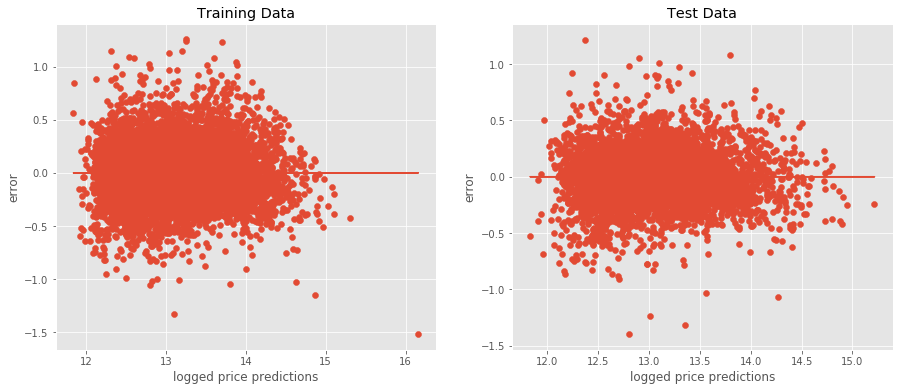

In [212]:
# let's look at the training set residuals:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

residuals_train6 = y_train_logged-y_train_pred6
ax1 = plt.subplot(121)
plt.scatter(y_train_pred6, residuals_train6)
plt.plot(y_train_pred6, [0 for i in range(len(y_train_pred6))])
plt.title('Training Data')
plt.xlabel('logged price predictions')
plt.ylabel('error')

residuals_test6 = y_test_logged-y_test_pred6
ax2 = plt.subplot(122)
plt.scatter(y_test_pred6, residuals_test6)
plt.plot(y_test_pred6, [0 for i in range(len(y_test_pred6))])
plt.title('Test Data')
plt.xlabel('logged price predictions')
plt.ylabel('error');

# looks better than the cone shape

In [213]:
# look at coefficients

model = sm.OLS(y_train_logged, sm.add_constant(pd.DataFrame(X_train6, columns=X_train6.columns, index=X_train6.index)))
results = model.fit()

results.summary()

# sqft_above and sqft_basement have high p-values
# experiment with removing these later

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     3923.
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        10:41:14   Log-Likelihood:                 1858.3
No. Observations:               15094   AIC:                            -3677.
Df Residuals:                   15074   BIC:                            -3524.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            16.8391      0.174     96.811      0.000      16.498      17.180
bedrooms         -0.0144      0.003     -5.740      0.000      -0.019      -0.009
bathrooms         0.0553      0.004     13.203      0.000       0.047       0.064
sqft_living       0.0002   2.41e-05      6.904      0.000       0.000       0.000
sqft_lot       6.225e-07   5.19e-08     11.991      0.000    5.21e-07    7.24e-07
floors            0.0249      0.005      5.047      0.000       0.015       0.035
condition         0.0417      0.003     14.093      0.000       0.036       0.048
grade             0.1218      0.003     44.308      0.000       0.116       0.127
sqft_above     1.064e-06    2.4e-05      0.044      0.965    -4.6e-05    4.81e-05
sqft_basement  1.217e-05   2.39e-05      0.510      0.610   -3.46e-05    5.89e-05
yr_built         -0.0028    8.6e-05    -32.521      0.000      -0.003      -0.003
sqft_living15     0.1625      0.009     18.450      0.000       0.145       0.180
sqft_lot15       -0.0286      0.003     -8.849      0.000      -0.035      -0.022
renovated         0.0619      0.010      6.075      0.000       0.042       0.082
Zip Class 2      -0.2840      0.038     -7.408      0.000      -0.359      -0.209
Zip Class 3      -0.5188      0.038    -13.749      0.000      -0.593      -0.445
Zip Class 4      -0.6294      0.038    -16.756      0.000      -0.703      -0.556
Zip Class 5      -0.8393      0.038    -22.268      0.000      -0.913      -0.765
Zip Class 6      -1.1203      0.038    -29.740      0.000      -1.194      -1.046
Zip Class 7      -1.2407      0.039    -31.768      0.000      -1.317      -1.164
==============================================================================
Omnibus:                      916.216   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3646.458
Skew:                           0.166   Prob(JB):                         0.00
Kurtosis:                       5.385   Cond. No.                     4.49e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.49e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [214]:
# which coefficients are most closely correlated with price?
X_train6.corrwith(y_train_logged).sort_values(ascending=False)

# grade and sqft_living, as in the original data

grade            0.70037
sqft_living      0.68844
sqft_living15    0.60843
sqft_above       0.59064
bathrooms        0.54322
bedrooms         0.34636
Zip Class 3      0.32898
Zip Class 2      0.32745
sqft_basement    0.30919
floors           0.30569
Zip Class 4      0.28081
sqft_lot15       0.12234
sqft_lot         0.10449
renovated        0.09658
yr_built         0.07662
condition        0.04812
Zip Class 5     -0.12749
Zip Class 7     -0.22372
Zip Class 6     -0.49803
dtype: float64

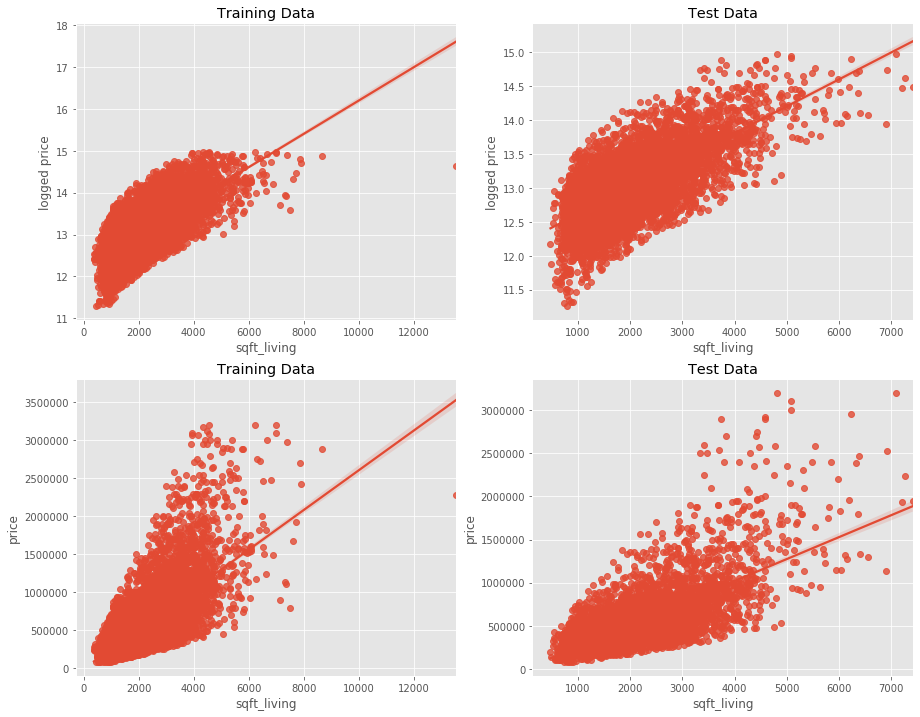

In [215]:
# plot coefficients that are closely correlated with price, for presentation to non-technical stakeholders

plt.subplots(figsize=(15,12));

ax1 = plt.subplot(221)
sns.regplot(X_train6['sqft_living'], y_train_logged)
plt.title('Training Data')
plt.ylabel('logged price')

ax2 = plt.subplot(222)
sns.regplot(X_test6['sqft_living'], y_test_logged)
plt.title('Test Data')
plt.ylabel('logged price')

ax3 = plt.subplot(223)
sns.regplot(X_train6['sqft_living'], y_train)
plt.title('Training Data')

ax4 = plt.subplot(224)
sns.regplot(X_test6['sqft_living'], y_test)
plt.title('Test Data');

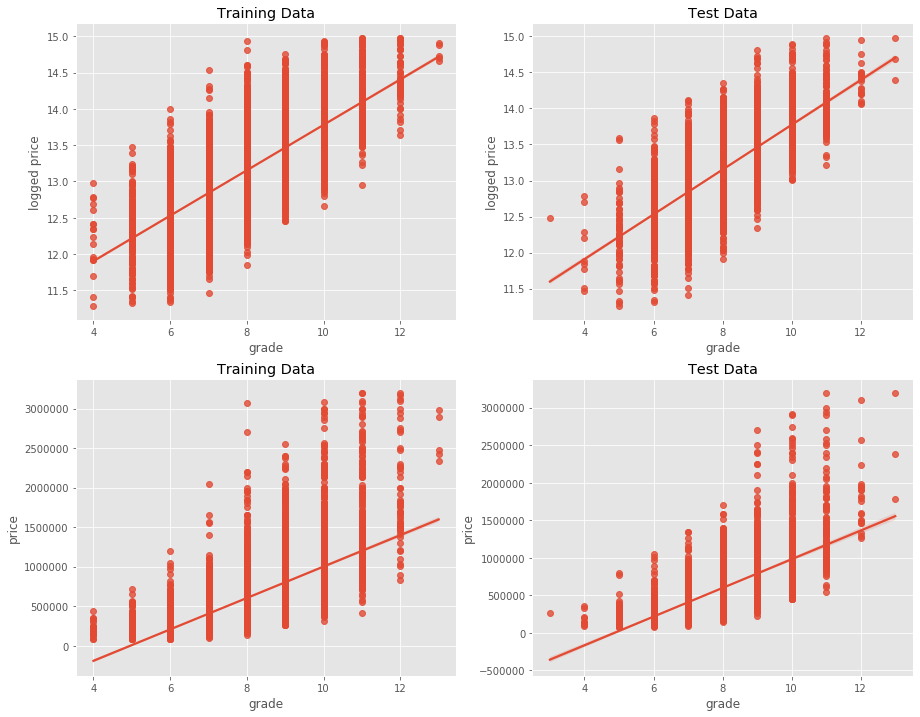

In [216]:
plt.subplots(figsize=(15,12));

ax1 = plt.subplot(221)
sns.regplot(X_train6['grade'], y_train_logged)
plt.title('Training Data')
plt.ylabel('logged price')

ax2 = plt.subplot(222)
sns.regplot(X_test6['grade'], y_test_logged)
plt.title('Test Data')
plt.ylabel('logged price')

ax3 = plt.subplot(223)
sns.regplot(X_train6['grade'], y_train)
plt.title('Training Data')

ax4 = plt.subplot(224)
sns.regplot(X_test6['grade'], y_test)
plt.title('Test Data');

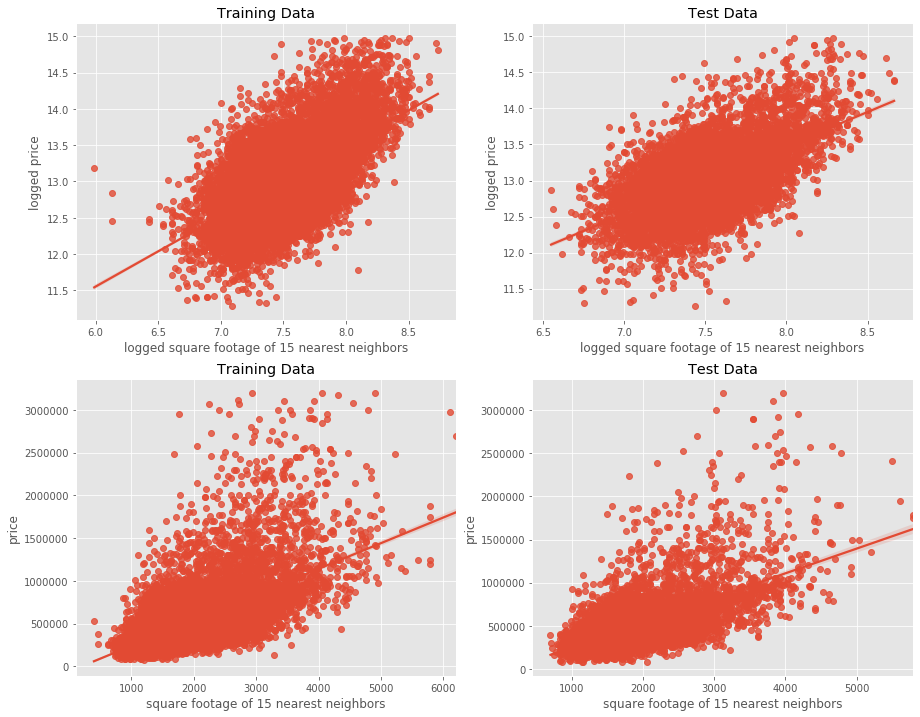

In [217]:
plt.subplots(figsize=(15,12));

ax1 = plt.subplot(221)
sns.regplot(X_train6['sqft_living15'], y_train_logged)
plt.title('Training Data')
plt.xlabel('logged square footage of 15 nearest neighbors')
plt.ylabel('logged price')

ax2 = plt.subplot(222)
sns.regplot(X_test6['sqft_living15'], y_test_logged)
plt.title('Test Data')
plt.xlabel('logged square footage of 15 nearest neighbors')
plt.ylabel('logged price')

ax3 = plt.subplot(223)
sns.regplot(np.expm1(X_train6['sqft_living15']), y_train)
plt.title('Training Data')
plt.xlabel('square footage of 15 nearest neighbors')

ax4 = plt.subplot(224)
sns.regplot(np.expm1(X_test6['sqft_living15']), y_test)
plt.title('Test Data')
plt.xlabel('square footage of 15 nearest neighbors');

### Model 7: Testing Removing Multicolinear Columns

In [218]:
# let's see if removing multicolinearity helps
# find top correlations
# code from Flatiron Data Science course's Multicollinearity Lab

df=X_train6.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates
df.drop_duplicates(inplace=True)

In [219]:
df[(df.cc>.75) & (df.cc <1)]

# high correlations among these four variables:
# sqft_living, sqft_above, grade, bathrooms

,cc
pairs,
"(sqft_above, sqft_living)",0.87414
"(sqft_living, grade)",0.76274
"(grade, sqft_above)",0.75252
"(bathrooms, sqft_living)",0.75168


In [220]:
best_r2

{'train': 0.831786, 'test': 0.824695}

In [221]:
# iterate thru combinations of highly correlated variables to see if dropping them increases r2

correlated = ['sqft_living',
              'sqft_above',
              'grade',
              'bathrooms']

combs_list=[]

for n in range(1,5):
    
    comb = combinations(correlated,n)
    combs_list = combs_list + list(comb)
    
combs_list

for c in combs_list: 
    print(c)
    X_train7 = X_train6.drop(columns = list(c))
    X_test7 = X_test6.drop(columns = list(c))
    y_train_pred7, y_test_pred7 = scale_lin_reg(X_train=X_train7, y_train=y_train_logged, X_test=X_test7)
    eval_r2(y_train=y_train_logged, y_train_pred=y_train_pred7, y_test=y_test_logged, y_test_pred=y_test_pred7)
    print('\n')

# despite the multicolinearity, dropping combinations of these columns does not result in an improved R2
# dropping sqft_above returns almost exactly the same result

('sqft_living',)
Training Data 
 R-Squared: 0.831254 

Test Data 
 R-Squared: 0.824034


('sqft_above',)
Training Data 
 R-Squared: 0.831786 

Test Data 
 R-Squared: 0.824694


('grade',)
Training Data 
 R-Squared: 0.809878 

Test Data 
 R-Squared: 0.80379


('bathrooms',)
Training Data 
 R-Squared: 0.829841 

Test Data 
 R-Squared: 0.823283


('sqft_living', 'sqft_above')
Training Data 
 R-Squared: 0.817787 

Test Data 
 R-Squared: 0.807807


('sqft_living', 'grade')
Training Data 
 R-Squared: 0.808786 

Test Data 
 R-Squared: 0.802657


('sqft_living', 'bathrooms')
Training Data 
 R-Squared: 0.829077 

Test Data 
 R-Squared: 0.822332


('sqft_above', 'grade')
Training Data 
 R-Squared: 0.809869 

Test Data 
 R-Squared: 0.803735


('sqft_above', 'bathrooms')
Training Data 
 R-Squared: 0.829838 

Test Data 
 R-Squared: 0.823292


('grade', 'bathrooms')
Training Data 
 R-Squared: 0.806922 

Test Data 
 R-Squared: 0.801808


('sqft_living', 'sqft_above', 'grade')
Training Data 
 R-Square

### Model 8: Test removing features with high p-values

In [222]:
# according to the statsmodels output, p-values for sqft_above and sqft_basement were above 0.05

X_train8 = X_train6.copy()
X_train8.drop(columns=['sqft_above', 'sqft_basement'], inplace=True)

X_test8 = X_test6.copy()
X_test8.drop(columns=['sqft_above', 'sqft_basement'], inplace=True)


In [223]:
y_train_pred8, y_test_pred8 = scale_lin_reg(X_train=X_train8, y_train=y_train_logged, X_test=X_test8)


In [224]:
eval_r2(y_train=y_train_logged, y_train_pred=y_train_pred8, y_test=y_test_logged, y_test_pred=y_test_pred8)


Training Data 
 R-Squared: 0.831739 

Test Data 
 R-Squared: 0.824666


In [225]:
unlog_MAE_RMSE(y_train=y_train, y_train_logged_pred=y_train_pred8, y_test=y_test, y_test_logged_pred=y_test_pred8)


Training Data 
 Mean Absolute Error: 90197.74 
 Root Mean Squared Error: 171178.9 

Test Data 
 Mean Absolute Error: 87315.2 
 Root Mean Squared Error: 144369.52 



In [226]:
best_r2
# no improvement in r2 for Model 8, but let's keep this model since at least it reduces multicolinearity
# and removes coefficients with high p-values

{'train': 0.831786, 'test': 0.824695}

In [227]:
# look at coefficients for Model 8

model = sm.OLS(y_train_logged, sm.add_constant(pd.DataFrame(X_train8, columns=X_train8.columns, index=X_train8.index)))
results = model.fit()

results.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     4384.
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        10:41:22   Log-Likelihood:                 1856.2
No. Observations:               15094   AIC:                            -3676.
Df Residuals:                   15076   BIC:                            -3539.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            16.8876      0.172     98.040      0.000      16.550      17.225
bedrooms         -0.0144      0.003     -5.750      0.000      -0.019      -0.009
bathrooms         0.0565      0.004     13.649      0.000       0.048       0.065
sqft_living       0.0002   4.31e-06     39.838      0.000       0.000       0.000
sqft_lot       6.263e-07   5.19e-08     12.074      0.000    5.25e-07    7.28e-07
floors            0.0203      0.004      4.661      0.000       0.012       0.029
condition         0.0422      0.003     14.278      0.000       0.036       0.048
grade             0.1211      0.003     44.434      0.000       0.116       0.126
yr_built         -0.0028   8.58e-05    -32.727      0.000      -0.003      -0.003
sqft_living15     0.1610      0.009     18.347      0.000       0.144       0.178
sqft_lot15       -0.0301      0.003     -9.518      0.000      -0.036      -0.024
renovated         0.0623      0.010      6.113      0.000       0.042       0.082
Zip Class 2      -0.2815      0.038     -7.346      0.000      -0.357      -0.206
Zip Class 3      -0.5165      0.038    -13.696      0.000      -0.590      -0.443
Zip Class 4      -0.6275      0.038    -16.711      0.000      -0.701      -0.554
Zip Class 5      -0.8378      0.038    -22.231      0.000      -0.912      -0.764
Zip Class 6      -1.1192      0.038    -29.713      0.000      -1.193      -1.045
Zip Class 7      -1.2397      0.039    -31.742      0.000      -1.316      -1.163
==============================================================================
Omnibus:                      920.209   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3659.161
Skew:                           0.169   Prob(JB):                         0.00
Kurtosis:                       5.388   Cond. No.                     4.45e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 9: Experiment with categorizing year built

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,sqft_lot15,renovated,Zip Class 2,Zip Class 3,Zip Class 4,Zip Class 5,Zip Class 6,Zip Class 7,price
14289,3,2.00000,1310,8440,1.00000,5,6,1951,7.48997,9.28498,0,0,0,0,0,1,0,223000.00000
1078,3,1.00000,1040,7541,1.00000,3,6,1951,7.03878,8.71604,0,0,0,0,1,0,0,325000.00000
14957,4,3.00000,2720,4800,1.50000,5,8,1928,7.72312,8.47637,0,0,1,0,0,0,0,1020000.00000
2179,5,2.50000,2450,20805,2.00000,4,9,1963,8.01301,9.91956,0,1,0,0,0,0,0,1550000.00000
4133,3,2.50000,1610,1320,2.00000,3,7,2007,7.29980,7.37901,0,0,0,1,0,0,0,399950.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11303,4,2.50000,2242,37451,2.00000,3,8,1995,7.71512,9.48227,0,0,0,0,1,0,0,490000.00000
11983,3,1.75000,1430,4920,1.00000,2,6,1957,7.34601,8.63870,0,0,0,0,1,0,0,175000.00000
5400,4,3.50000,2720,6781,2.00000,3,8,1999,7.73193,8.68980,0,0,0,0,0,1,0,365000.00000
860,1,0.75000,380,15000,1.00000,3,5,1963,7.06476,9.61581,0,0,0,0,0,0,1,245000.00000


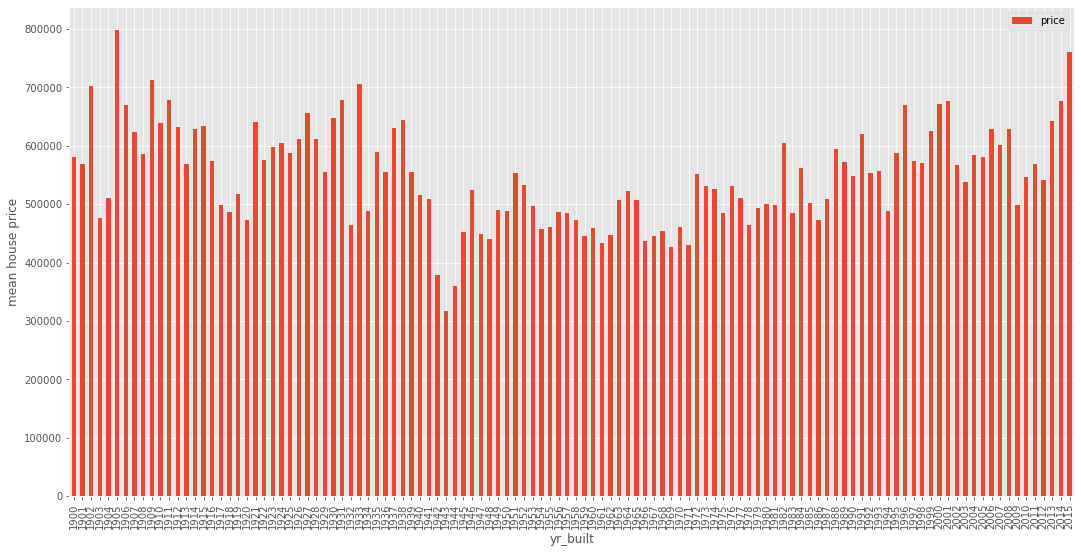

In [228]:
# made a df to add price back to X variables table, so we can make a pivot table
built_df = pd.concat([X_train8, y_train], axis=1)
built_pivot = built_df.pivot_table(values='price', index='yr_built', ).sort_values(by='yr_built')

# plot a bar graph to look at possible categories
built_pivot.plot(kind='bar', figsize=(18,9))
plt.ylabel('mean house price')
plt.legend;

built_df

# hmmm, almost looks like older homes and new homes are highly valued, while homes in the middle are not

In [229]:
# create a dictionary of years, showing the corresponding categories

years_list = list(built_pivot.index)
years_dict = {}

for i in years_list[0:41]:
    years_dict[i] = 'pre-war'
    
for i in years_list[41:88]:
    years_dict[i] = 'mid-century'

for i in years_list[88:117]:
    years_dict[i] = 'recent'
    
years_dict

{1900: 'pre-war',
 1901: 'pre-war',
 1902: 'pre-war',
 1903: 'pre-war',
 1904: 'pre-war',
 1905: 'pre-war',
 1906: 'pre-war',
 1907: 'pre-war',
 1908: 'pre-war',
 1909: 'pre-war',
 1910: 'pre-war',
 1911: 'pre-war',
 1912: 'pre-war',
 1913: 'pre-war',
 1914: 'pre-war',
 1915: 'pre-war',
 1916: 'pre-war',
 1917: 'pre-war',
 1918: 'pre-war',
 1919: 'pre-war',
 1920: 'pre-war',
 1921: 'pre-war',
 1922: 'pre-war',
 1923: 'pre-war',
 1924: 'pre-war',
 1925: 'pre-war',
 1926: 'pre-war',
 1927: 'pre-war',
 1928: 'pre-war',
 1929: 'pre-war',
 1930: 'pre-war',
 1931: 'pre-war',
 1932: 'pre-war',
 1933: 'pre-war',
 1934: 'pre-war',
 1935: 'pre-war',
 1936: 'pre-war',
 1937: 'pre-war',
 1938: 'pre-war',
 1939: 'pre-war',
 1940: 'pre-war',
 1941: 'mid-century',
 1942: 'mid-century',
 1943: 'mid-century',
 1944: 'mid-century',
 1945: 'mid-century',
 1946: 'mid-century',
 1947: 'mid-century',
 1948: 'mid-century',
 1949: 'mid-century',
 1950: 'mid-century',
 1951: 'mid-century',
 1952: 'mid-century'

In [230]:
# add a column with yr_built categories

built_df['built_cat'] = built_df['yr_built'].map(lambda x: years_dict[x])
built_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,sqft_lot15,renovated,Zip Class 2,Zip Class 3,Zip Class 4,Zip Class 5,Zip Class 6,Zip Class 7,price,built_cat
14289,3,2.00000,1310,8440,1.00000,5,6,1951,7.48997,9.28498,0,0,0,0,0,1,0,223000.00000,mid-century
1078,3,1.00000,1040,7541,1.00000,3,6,1951,7.03878,8.71604,0,0,0,0,1,0,0,325000.00000,mid-century
14957,4,3.00000,2720,4800,1.50000,5,8,1928,7.72312,8.47637,0,0,1,0,0,0,0,1020000.00000,pre-war
2179,5,2.50000,2450,20805,2.00000,4,9,1963,8.01301,9.91956,0,1,0,0,0,0,0,1550000.00000,mid-century
4133,3,2.50000,1610,1320,2.00000,3,7,2007,7.29980,7.37901,0,0,0,1,0,0,0,399950.00000,recent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11303,4,2.50000,2242,37451,2.00000,3,8,1995,7.71512,9.48227,0,0,0,0,1,0,0,490000.00000,recent
11983,3,1.75000,1430,4920,1.00000,2,6,1957,7.34601,8.63870,0,0,0,0,1,0,0,175000.00000,mid-century
5400,4,3.50000,2720,6781,2.00000,3,8,1999,7.73193,8.68980,0,0,0,0,0,1,0,365000.00000,recent
860,1,0.75000,380,15000,1.00000,3,5,1963,7.06476,9.61581,0,0,0,0,0,0,1,245000.00000,mid-century


In [231]:
# one hot encode classification column

built_cat_columns = pd.get_dummies(built_df['built_cat'], drop_first=True)
built_cat_columns

built_df = pd.concat([built_df, built_cat_columns], axis=1)
built_df.drop(columns=['yr_built','built_cat'], inplace=True)

In [232]:
built_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_living15,sqft_lot15,renovated,Zip Class 2,Zip Class 3,Zip Class 4,Zip Class 5,Zip Class 6,Zip Class 7,price,pre-war,recent
14289,3,2.00000,1310,8440,1.00000,5,6,7.48997,9.28498,0,0,0,0,0,1,0,223000.00000,0,0
1078,3,1.00000,1040,7541,1.00000,3,6,7.03878,8.71604,0,0,0,0,1,0,0,325000.00000,0,0
14957,4,3.00000,2720,4800,1.50000,5,8,7.72312,8.47637,0,0,1,0,0,0,0,1020000.00000,1,0
2179,5,2.50000,2450,20805,2.00000,4,9,8.01301,9.91956,0,1,0,0,0,0,0,1550000.00000,0,0
4133,3,2.50000,1610,1320,2.00000,3,7,7.29980,7.37901,0,0,0,1,0,0,0,399950.00000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11303,4,2.50000,2242,37451,2.00000,3,8,7.71512,9.48227,0,0,0,0,1,0,0,490000.00000,0,1
11983,3,1.75000,1430,4920,1.00000,2,6,7.34601,8.63870,0,0,0,0,1,0,0,175000.00000,0,0
5400,4,3.50000,2720,6781,2.00000,3,8,7.73193,8.68980,0,0,0,0,0,1,0,365000.00000,0,1
860,1,0.75000,380,15000,1.00000,3,5,7.06476,9.61581,0,0,0,0,0,0,1,245000.00000,0,0


In [233]:
# now we just have to stick these columns back onto the training and test sets

#training set first
X_train9 = X_train8.copy()

columns_to_add = built_df[['pre-war', 'recent']]
X_train9 = pd.concat([X_train9, columns_to_add], axis=1)
X_train9.drop(columns='yr_built', inplace=True)

In [234]:
# now do test set

X_test9 = X_test8.copy()

X_test9['built_cat'] = X_test9['yr_built'].map(lambda x: years_dict[x])
built_cat_columns = pd.get_dummies(X_test9['built_cat'], drop_first=True)

X_test9 = pd.concat([X_test9, built_cat_columns], axis=1)
X_test9.drop(columns=['yr_built','built_cat'], inplace=True)

X_test9

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_living15,sqft_lot15,renovated,Zip Class 2,Zip Class 3,Zip Class 4,Zip Class 5,Zip Class 6,Zip Class 7,pre-war,recent
8742,3,2.50000,1260,1125,3.00000,3,8,7.21524,7.13090,0,0,0,1,0,0,0,0,1
5170,3,1.75000,1530,8800,1.00000,4,7,7.33302,9.06993,0,0,0,0,0,1,0,0,0
8304,5,2.00000,2300,7897,2.50000,4,8,7.61579,8.97487,0,0,0,0,1,0,0,0,0
10599,2,2.25000,1290,1334,3.00000,3,8,7.20786,7.19594,0,0,0,1,0,0,0,0,1
21212,3,2.00000,1680,5246,1.00000,3,7,7.79565,8.83681,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20730,3,2.50000,2424,6143,2.00000,3,9,7.77528,8.70550,0,0,0,0,0,1,0,0,1
12013,4,2.00000,3210,8400,1.50000,5,7,7.83992,8.77307,0,0,0,1,0,0,0,1,0
5234,3,1.50000,1520,7123,1.00000,4,7,7.27932,8.99007,0,0,0,0,1,0,0,0,0
15268,3,1.00000,1060,9506,1.00000,3,7,7.32647,9.04417,0,0,0,0,1,0,0,0,0


In [235]:
# let's test model 9!

y_train_pred9, y_test_pred9 = scale_lin_reg(X_train=X_train9, y_train=y_train_logged, X_test=X_test9)

In [236]:
eval_r2(y_train=y_train_logged, y_train_pred=y_train_pred9, y_test=y_test_logged, y_test_pred=y_test_pred9)

# R-squared is less than for Model 8
# so, segmenting year_built into categories does not help explain any variance
# perhaps this variance can be explained by square footage and location alone

Training Data 
 R-Squared: 0.829755 

Test Data 
 R-Squared: 0.823546


In [237]:
best_r2

{'train': 0.831786, 'test': 0.824695}

In [238]:
model = sm.OLS(y_train_logged, sm.add_constant(pd.DataFrame(X_train9, columns=X_train9.columns, index=X_train9.index)))
results = model.fit()

results.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     4082.
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        10:41:23   Log-Likelihood:                 1767.7
No. Observations:               15094   AIC:                            -3497.
Df Residuals:                   15075   BIC:                            -3353.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            11.5075      0.073    158.508      0.000      11.365      11.650
bedrooms         -0.0101      0.003     -3.957      0.000      -0.015      -0.005
bathrooms         0.0374      0.004      9.153      0.000       0.029       0.045
sqft_living       0.0002    4.3e-06     41.720      0.000       0.000       0.000
sqft_lot       5.669e-07   5.25e-08     10.796      0.000    4.64e-07     6.7e-07
floors           -0.0084      0.005     -1.768      0.077      -0.018       0.001
condition         0.0522      0.003     17.465      0.000       0.046       0.058
grade             0.1161      0.003     42.588      0.000       0.111       0.121
sqft_living15     0.1412      0.009     15.964      0.000       0.124       0.159
sqft_lot15       -0.0230      0.003     -7.041      0.000      -0.029      -0.017
renovated         0.0926      0.010      9.109      0.000       0.073       0.113
Zip Class 2      -0.2880      0.039     -7.470      0.000      -0.364      -0.212
Zip Class 3      -0.5345      0.038    -14.088      0.000      -0.609      -0.460
Zip Class 4      -0.6537      0.038    -17.309      0.000      -0.728      -0.580
Zip Class 5      -0.8621      0.038    -22.746      0.000      -0.936      -0.788
Zip Class 6      -1.1530      0.038    -30.446      0.000      -1.227      -1.079
Zip Class 7      -1.2652      0.039    -32.214      0.000      -1.342      -1.188
pre-war           0.1532      0.006     27.459      0.000       0.142       0.164
recent           -0.0303      0.006     -5.232      0.000      -0.042      -0.019
==============================================================================
Omnibus:                      983.525   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3668.693
Skew:                           0.241   Prob(JB):                         0.00
Kurtosis:                       5.367   Cond. No.                     2.66e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.66e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [239]:
# future tweaks

# use automated feature selection methods?

# use min/max scalar for binary columns? - not a hard and fast rule but maybe will help
# model with just continuous? - didn't work

# look for interactions?
# try different train/test splits
# look at month sold?
# if model predicts something, e.g. over a million, go to a different model?

# instead of having the year renovated and the year built, 
# would it help to have a column for built or renovated in the past 10 or 20 years?